# Team 3 starter code

### Import our libraries

### Team 3 consists of Wilhelm Kamptner, Will Jackson, and Sam Thomas

This code is a repurpose of the original Fannie Mae Net Loss python notebook and utilizes many of the functions and features present in that notebook.

Our goal is to calculate a predicted net loss for a portfolio looking at the Fannie Mae data set that was provided.  This model is used as a proof-of-concept to our proposed client (Wells Fargo) in order to convince them that we are able to help push them to an automated process in order to stay competitive in the marketplace.

We utilized a Random Forest and Boosted Gradient tree model to do our final predictions.

Import our libraries, I have added in a couple of additional packages but otherwise left this untouched.

In [1]:
# this is just copied and pasted from the other starter codes
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import dill
import random
import sys

from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict, RandomizedSearchCV
from xgboost import XGBRegressor, XGBClassifier

from patsy import dmatrices, dmatrix, build_design_matrices

# Set number of CPU cores for parallel algorithms
import os
if "CPU_LIMIT" in os.environ:
    # If you are on JupyterHub, this gives you the right number of CPUs for your virtual machine
    num_cpus = int(os.getenv("CPU_LIMIT").split('.')[0])
else:
    # If you are not on JupyterHub, this gives you the right number for your computer.
    num_cpus = os.cpu_count()

This is the default dataframe display settings found in other notebooks

In [2]:
# This sets some nicer defaults for plotting.
# This must be run in a separate cell from importing matplotlib due to a bug.
params = {'legend.fontsize': 'large',
          'figure.figsize': (11.0, 11.0),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# This makes it so that the pandas dataframes don't get truncated horizontally.
pd.options.display.max_columns = 200

#### random state variable
The default random state is `201` but you can change this to any number and it'll input this into all of the random_state parameters.  We used this to run the model with different random states to compare results.

In [3]:
rs = 201

### Load our data

In [4]:
col_classes = {"LOAN_IDENTIFIER": np.character, 
               "CHANNEL": 'category', 
               "SELLER_NAME": np.character, 
               "ORIGINAL_INTEREST_RATE": np.float32, 
               "ORIGINAL_UPB": np.float64,
               "ORIGINAL_LOAN_TERM": "Int16", 
               "ORIGINATION_DATE": np.character,
               "FIRST_PAYMENT_DATE": np.character, 
               "ORIGINAL_LTV": np.float32, 
               "ORIGINAL_COMBINED_LTV": np.float32, 
               "NUMBER_OF_BORROWERS": 'category', 
               "DTI": np.float32, 
               "BORROWER_CREDIT_SCORE_AT_ORIGINATION": "UInt16", 
               "COBORROWER_CREDIT_SCORE_AT_ORIGINATION": 'UInt16', 
               "FIRST_TIME_HOME_BUYER_INDICATOR": 'category', 
               "LOAN_PURPOSE": 'category', 
               "PROPERTY_TYPE": 'category',
               "NUMBER_OF_UNITS": "UInt16", 
               "OCCUPANCY_STATUS": 'category', 
               "PROPERTY_STATE": 'category', 
               "MSA": 'category', 
               "ZIP_CODE_SHORT": 'category', 
               "MORTGAGE_INSURANCE_PERCENTAGE": np.float32, 
               "AMORTIZATION_TYPE": np.character,
               "MORTGAGE_INSURANCE_TYPE": 'category', 
               "RELOCATION_MORTGAGE_INDICATOR": 'category',
               "CREDIT_SCORE_MIN": "UInt16",
               "ORIGINAL_VALUE": float,
               "ZERO_BALANCE_CODE": 'category',
               "LOAN_AGE": "Int16",
               "NET_LOSS": float,
               "NET_SEVERITY": float,
               "LAST_STAT": 'category',
               "LOAN_MODIFICATION_COSTS": float,
               "TOTAL_LOSSES": float,
               "MSA_NAME": 'category',
               "CENSUS_2010_POP": float}

date_columns = ["ORIGINATION_DATE",
                "FIRST_PAYMENT_DATE"]

Below is just column categorizations that are from the original Fannie Mae Jupyter notebook

In [5]:
col_classes = {"LOAN_IDENTIFIER": np.character, 
               "CHANNEL": 'category', 
               "SELLER_NAME": np.character, 
               "ORIGINAL_INTEREST_RATE": np.float32, 
               "ORIGINAL_UPB": np.float64,
               "ORIGINAL_LOAN_TERM": "Int16", 
               "ORIGINATION_DATE": np.character,
               "FIRST_PAYMENT_DATE": np.character, 
               "ORIGINAL_LTV": np.float32, 
               "ORIGINAL_COMBINED_LTV": np.float32, 
               "NUMBER_OF_BORROWERS": 'category', 
               "DTI": np.float32, 
               "BORROWER_CREDIT_SCORE_AT_ORIGINATION": "UInt16", 
               "COBORROWER_CREDIT_SCORE_AT_ORIGINATION": 'UInt16', 
               "FIRST_TIME_HOME_BUYER_INDICATOR": 'category', 
               "LOAN_PURPOSE": 'category', 
               "PROPERTY_TYPE": 'category',
               "NUMBER_OF_UNITS": "UInt16", 
               "OCCUPANCY_STATUS": 'category', 
               "PROPERTY_STATE": 'category', 
               "MSA": 'category', 
               "ZIP_CODE_SHORT": 'category', 
               "MORTGAGE_INSURANCE_PERCENTAGE": np.float32, 
               "AMORTIZATION_TYPE": np.character,
               "MORTGAGE_INSURANCE_TYPE": 'category', 
               "RELOCATION_MORTGAGE_INDICATOR": 'category',
               "CREDIT_SCORE_MIN": "UInt16",
               "ORIGINAL_VALUE": float,
               "ZERO_BALANCE_CODE": 'category',
               "LOAN_AGE": "Int16",
               "NET_LOSS": float,
               "NET_SEVERITY": float,
               "LAST_STAT": 'category',
               "LOAN_MODIFICATION_COSTS": float,
               "TOTAL_LOSSES": float,
               "MSA_NAME": 'category',
               "CENSUS_2010_POP": float}

date_columns = ["ORIGINATION_DATE",
                "FIRST_PAYMENT_DATE"]

We were not able to utilize the full data set due to sheer volume and technical constraints.  Our models have only been tested on the FannieMaeSmallTrain data as there just did not exist the hardware to run through a data set this large.

In [6]:
%%time

full_data_set = False  #Here is where you should change to True to use the full data
# difficulty running the full dataset or even half

FILES_LOCATION = '../Shared Data (Read Only)/Fannie Mae Data/'

if not full_data_set:
    df_train = pd.read_csv(FILES_LOCATION + "FannieMaeSmallTrain.csv",
                           index_col="LOAN_IDENTIFIER",
                           dtype=col_classes,
                           parse_dates=date_columns,
                           sep='|')
    df_test = pd.read_csv(FILES_LOCATION + "FannieMaeSmallTest.csv",
                          index_col="LOAN_IDENTIFIER",
                          dtype=col_classes,
                          parse_dates=date_columns,
                          sep='|')

if full_data_set:
    # This p is the proportion of the training data you load.
    # You can set it anywhere from 0 to 1.  Difficulty with 1, .5.
    p = 1
    random.seed(rs)
    df_train = pd.read_csv(FILES_LOCATION + "FannieMaeTrain.csv",
                           index_col="LOAN_IDENTIFIER",
                           dtype=col_classes,
                           parse_dates=date_columns,
                           sep='|',
                           skiprows=lambda i: i>0 and random.random() > p)
    df_test = pd.read_csv(FILES_LOCATION + "FannieMaeTest.csv",
                          index_col="LOAN_IDENTIFIER",
                          dtype=col_classes,
                          parse_dates=date_columns,
                          sep='|')

CPU times: user 6.28 s, sys: 301 ms, total: 6.58 s
Wall time: 6.6 s


In [7]:
print("The training data shape is: " + str(df_train.shape))
print("The training data shape is: " + str(df_test.shape))
if df_train.shape != df_test.shape:
    print("Shapes are different sizes, something went wrong.  Go back and recheck above")
    sys.exit() #prevent further execution until dataframe sizing issues are resolved
else:
    print("Good to go!")


The training data shape is: (493073, 36)
The training data shape is: (493073, 36)
Good to go!


# IMPORTANT

### Below is the start of the distinct code to generate NET LOSS approach, a linear regression approach to the final project data.

Below is default code that drops columns not to be included in our analysis due to the fact that they leak future data into the dataset we are trying to predict on.  These are included in the original Fannie Mae jupyter code

In [8]:
if 'ZERO_BALANCE_CODE' in df_train:
    df_train.drop(['ZERO_BALANCE_CODE', 'LOAN_AGE', 'NET_SEVERITY', 'LAST_STAT', 'LOAN_MODIFICATION_COSTS', 'TOTAL_LOSSES'],
                  axis=1,
                  inplace=True)
if 'ZERO_BALANCE_CODE' in df_test:
    df_test.drop(['ZERO_BALANCE_CODE', 'LOAN_AGE', 'NET_SEVERITY', 'LAST_STAT', 'LOAN_MODIFICATION_COSTS', 'TOTAL_LOSSES'],
                  axis=1,
                  inplace=True)

In [9]:
def summarize_dataframe(df):
    """Summarize a dataframe, and report missing values."""
    missing_values = pd.DataFrame({'Variable Name': df.columns,
                                   'Data Type': df.dtypes,
                                   'Missing Values': df.isnull().sum(),
                                   'Unique Values': [df[name].nunique() for name in df.columns]}
                                 ).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all', datetime_is_numeric=True).transpose()], axis=1).fillna(""))

### Summarize our data

These are from the original class Jupyter Notebook and are used to just analyze our dataframes.  These were helpful as part of our data discovery process at the start of this project, however I have collapsed them now as they are not necessary anymore but I did not want to omit them.

In [10]:
summarize_dataframe(df_train) 

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,min,25%,50%,75%,max,std
CHANNEL,category,0,3,493073.0,3,R,257680,,,,,,,
SELLER_NAME,object,0,143,493073.0,143,Other,180983,,,,,,,
ORIGINAL_INTEREST_RATE,float32,1,1960,493072.0,,,,4.917918,1.75,3.875,4.75,5.875,12.125,1.381413
ORIGINAL_UPB,float64,0,831,493073.0,,,,205186.96623,6000.0,116000.0,179000.0,269000.0,1269000.0,118997.809289
ORIGINAL_LOAN_TERM,Int16,0,204,493073.0,,,,310.4345,60.0,240.0,360.0,360.0,360.0,80.317014
ORIGINATION_DATE,datetime64[ns],0,267,493073.0,,,,2010-09-17 11:51:27.021191680,1999-01-19 00:00:00,2003-07-20 00:00:00,2010-11-20 00:00:00,2016-11-20 00:00:00,2021-03-20 00:00:00,
FIRST_PAYMENT_DATE,datetime64[ns],0,267,493073.0,,,,2010-11-17 13:53:54.489822208,1999-03-19 00:00:00,2003-09-20 00:00:00,2011-01-20 00:00:00,2017-01-20 00:00:00,2021-05-20 00:00:00,
ORIGINAL_LTV,float32,0,96,493073.0,,,,70.482384,2.0,60.0,75.0,80.0,97.0,17.552217
ORIGINAL_COMBINED_LTV,float32,0,124,493073.0,,,,71.231705,2.0,61.0,75.0,80.0,158.0,17.620892
NUMBER_OF_BORROWERS,category,109,7,492964.0,7,2,273507,,,,,,,


In [11]:
summarize_dataframe(df_test)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,min,25%,50%,75%,max,std
CHANNEL,category,0,3,493073.0,3,R,257609,,,,,,,
SELLER_NAME,object,0,144,493073.0,144,Other,181007,,,,,,,
ORIGINAL_INTEREST_RATE,float32,0,1994,493073.0,,,,4.917481,1.75,3.875,4.75,5.875,11.625,1.384845
ORIGINAL_UPB,float64,0,844,493073.0,,,,205485.463613,8000.0,116000.0,179000.0,270000.0,1473000.0,119123.262314
ORIGINAL_LOAN_TERM,Int16,0,201,493073.0,,,,310.492996,60.0,240.0,360.0,360.0,360.0,80.312096
ORIGINATION_DATE,datetime64[ns],0,267,493073.0,,,,2010-09-17 05:33:07.161333248,1999-01-19 00:00:00,2003-07-20 00:00:00,2010-11-20 00:00:00,2016-11-20 00:00:00,2021-03-20 00:00:00,
FIRST_PAYMENT_DATE,datetime64[ns],0,267,493073.0,,,,2010-11-17 07:39:02.274673408,1999-03-19 00:00:00,2003-09-20 00:00:00,2011-01-20 00:00:00,2017-01-20 00:00:00,2021-05-20 00:00:00,
ORIGINAL_LTV,float32,0,97,493073.0,,,,70.454559,1.0,60.0,75.0,80.0,97.0,17.539341
ORIGINAL_COMBINED_LTV,float32,0,127,493073.0,,,,71.187462,1.0,61.0,75.0,80.0,157.0,17.601181
NUMBER_OF_BORROWERS,category,101,9,492972.0,9,2,273611,,,,,,,


## Engineer and Feature Building

Here is the start of our features.  We kept in the YEAR column as we found it very helpful as part of our analysis and approach.

We also engineer a couple of other tools that would help narrow down our dataset for the purpose of our presentation.
The first is our Wells Fargo list and filter.  The `wf_list` code block, a few cells down, iterates through the SELLER_NAMES and looks for "Wells Fargo" names and creates a list which will then be later used as a filter on the data to only look at Wells Fargo data.
This is an optional function.  By default, we run this code with `only_wf` set to FALSE.  Setting `only_wf` to TRUE will filter your datasets

Here, we convert ORIGINATION_DATE into a datetime datatype, as well as pulling out the year into it's own column called YEAR.

We have also decided to build out additional break downs as part of our data discovery process.

In [12]:
df_train['ORIGINATION_DATE'] = pd.to_datetime(df_train['ORIGINATION_DATE'], format='%Y-%m-%d')

df_test['ORIGINATION_DATE'] = pd.to_datetime(df_test['ORIGINATION_DATE'], format='%Y-%m-%d')

### Purchase Price

This formula was found in a Fannie Mae training presentation which took the original loan amount over the original loan-to-value ration divided by 100.  This is the assumed purchase price.

This ended up being the original value formula, but we wrote the code so we're gonna include it in our formula.

In [13]:
df_train['Purchase_Price'] = df_train['ORIGINAL_UPB']/(df_train['ORIGINAL_LTV']/100)
df_test['Purchase_Price'] = df_test['ORIGINAL_UPB']/(df_test['ORIGINAL_LTV']/100)

In [14]:
df_train.head()

,CHANNEL,SELLER_NAME,ORIGINAL_INTEREST_RATE,ORIGINAL_UPB,ORIGINAL_LOAN_TERM,ORIGINATION_DATE,FIRST_PAYMENT_DATE,ORIGINAL_LTV,ORIGINAL_COMBINED_LTV,NUMBER_OF_BORROWERS,DTI,BORROWER_CREDIT_SCORE_AT_ORIGINATION,COBORROWER_CREDIT_SCORE_AT_ORIGINATION,FIRST_TIME_HOME_BUYER_INDICATOR,LOAN_PURPOSE,PROPERTY_TYPE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,PROPERTY_STATE,MSA,ZIP_CODE_SHORT,MORTGAGE_INSURANCE_PERCENTAGE,AMORTIZATION_TYPE,MORTGAGE_INSURANCE_TYPE,RELOCATION_MORTGAGE_INDICATOR,CREDIT_SCORE_MIN,ORIGINAL_VALUE,NET_LOSS,MSA_NAME,CENSUS_2010_POP,Purchase_Price
LOAN_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
140567020154,R,Other,4.375,212000.0,360,2017-10-20,2017-12-20,90.0,90.0,2,48.0,770,798,Y,P,MH,1,P,OR,0,974,25.0,FRM,1,N,770,235555.561796,0.0,NaN,NaN,235555.561796
393621392406,B,"Jpmorgan Chase Bank, National Association",6.000,85000.0,180,2002-07-20,2002-09-20,39.0,39.0,2,20.0,786,<NA>,N,R,PU,1,P,OK,36420,730,NaN,FRM,NaN,N,786,217948.725943,0.0,"Oklahoma City, OK",1252987.0,217948.725943
108425322431,R,Other,4.850,110000.0,180,2003-07-20,2003-09-20,58.0,58.0,2,27.0,780,792,N,R,SF,1,P,WI,24580,541,NaN,FRM,NaN,N,780,189655.177871,0.0,"Green Bay, WI",306241.0,189655.177871
912304395556,C,"Bank Of America, N.A.",8.250,126000.0,360,2000-03-20,2000-05-20,72.0,72.0,2,57.0,753,755,N,P,PU,1,P,NV,29820,890,NaN,FRM,NaN,N,753,174999.993046,0.0,"Las Vegas-Henderson-Paradise, NV",1951269.0,174999.993046
400817966732,C,Other,6.910,53000.0,360,2001-09-20,2001-11-20,90.0,90.0,2,42.0,747,<NA>,Y,P,SF,1,P,MO,41180,631,25.0,FRM,1,N,747,58888.890449,0.0,"St. Louis, MO-IL",2787701.0,58888.890449


In [15]:
df_train['YEAR'] = df_train['ORIGINATION_DATE'].dt.year
df_train['month'] = df_train['ORIGINATION_DATE'].dt.month
df_train['hour'] = df_train['ORIGINATION_DATE'].dt.hour
df_train['weekday'] = df_train['ORIGINATION_DATE'].dt.dayofweek




df_test['YEAR'] = df_test['ORIGINATION_DATE'].dt.year
df_test['month'] = df_test['ORIGINATION_DATE'].dt.month
df_test['hour'] = df_test['ORIGINATION_DATE'].dt.hour
df_test['weekday'] = df_test['ORIGINATION_DATE'].dt.dayofweek

In [16]:
df_train.shape

(493073, 35)

Below:  iterate through all seller names and append any matches where "Wells Fargo" exists to a blank list.

Print is for dev purposes only.

The goal of this feature was to provide a filter down look on Wells Fargo data points which were done for some preliminary analysis, but we do not run the Wells Fargo exclusive data through our model as it is not the intention to run a significantly smaller data set through our models.  However, we did use this feature to see how Wells Fargo compares to the data at large, as well as provide a proof of concept of how we might filter on specific clients data.  We ultimately decided that in order to appeal to our client (Wells Fargo), we would need to build a model specifically catered for their business and their data, but provide our full fannie mae data ran models as proof of our ability to generate a model that works.

### Regions
We have too many states, so I have decided to categorize the states into 5 total categories.  North East, Mid-West, South, West, and "Other" which will encompass all territories and regions outside OCONUS.

I first create lists of all the state names, then create a new column called 'Region' where I fill based on the conditional value of PROPERTY_STATE

In [17]:
NE=["CT","ME","MA","NH","RI","VT","NJ","NY","PA"]

MW=["IN","IL","MI","OH","WI","IA","KS","MN","MO","NE","ND","SD"]

S=["DE","DC","FL","GA","MD","NC","SC","VA","WV","AL","KY","MS","TN","AR","LA","OK","TX"]

W=["AZ","CO","ID","NM","MT","UT","NV","WY","AK","CA","HI","OR","WA"]

In [18]:
df_train['PROPERTY_STATE']

LOAN_IDENTIFIER
140567020154    OR
393621392406    OK
108425322431    WI
912304395556    NV
400817966732    MO
                ..
98754577        NV
719590016519    MI
520292862302    TX
686297093570    AZ
295475581662    UT
Name: PROPERTY_STATE, Length: 493073, dtype: category
Categories (54, object): ['AK', 'AL', 'AR', 'AZ', ..., 'WA', 'WI', 'WV', 'WY']

In [19]:
# creating my column region
df_train['Region']=""
df_test['Region']=""

In [ ]:
# populate column where state matches list
df_train['Region'] =np.where(df_train['PROPERTY_STATE'].isin(NE), "NE", df_train['Region'])
df_train['Region'] =np.where(df_train['PROPERTY_STATE'].isin(MW), "MW",df_train['Region'])
df_train['Region'] =np.where(df_train['PROPERTY_STATE'].isin(S), "S",df_train['Region'])
df_train['Region'] =np.where(df_train['PROPERTY_STATE'].isin(W), "W",df_train['Region'])
df_train['Region'] = np.where(df_train['Region']=="", "Other", df_train['Region'])

In [21]:
df_test['Region'] =np.where(df_test['PROPERTY_STATE'].isin(NE), "NE", df_test['Region'])
df_test['Region'] =np.where(df_test['PROPERTY_STATE'].isin(MW), "MW",df_test['Region'])
df_test['Region'] =np.where(df_test['PROPERTY_STATE'].isin(S), "S",df_test['Region'])
df_test['Region'] =np.where(df_test['PROPERTY_STATE'].isin(W), "W",df_test['Region'])
df_test['Region'] = np.where(df_test['Region']=="", "Other", df_test['Region'])

In [22]:
df_train['PROPERTY_STATE'].unique()

['OR', 'OK', 'WI', 'NV', 'MO', ..., 'GU', 'WY', 'DC', 'AK', 'VI']
Length: 54
Categories (54, object): ['AK', 'AL', 'AR', 'AZ', ..., 'WA', 'WI', 'WV', 'WY']

In [23]:
df_train['Region'].unique()

array(['W', 'S', 'MW', 'NE', 'Other'], dtype=object)

In [24]:
df_train.groupby(['Region']).size()

Region
MW       111663
NE        73763
Other      1354
S        152767
W        153526
dtype: int64

In [25]:
wf_list = [] # create empty list
for i in df_test.SELLER_NAME.unique(): # for all unique SELLER_NAMEs in the data
    if i.find("Wells Fargo") != -1: # if the string Wells Fargo exists
        print(i) # print for dev purposes
        wf_list.append(i) # append this Wells Fargo related name into the empty list

for i in df_train.SELLER_NAME.unique():
    if i.find("Wells Fargo") != -1:
        print(i)
        wf_list.append(i)

Wells Fargo Bank, N.A.
Wells Fargo Bank,  Na
Wells Fargo Credit Risk Transfer Securities Trust 2015
Wells Fargo Bank, N.A.
Wells Fargo Bank,  Na
Wells Fargo Credit Risk Transfer Securities Trust 2015


Below, we are looking to see which rows of data are Wells Fargo and which ones are not, this is just a check to make sure our above code worked

In [26]:
df_train.SELLER_NAME.isin(wf_list)

LOAN_IDENTIFIER
140567020154    False
393621392406    False
108425322431    False
912304395556    False
400817966732    False
                ...  
98754577        False
719590016519    False
520292862302    False
686297093570    False
295475581662     True
Name: SELLER_NAME, Length: 493073, dtype: bool

#### Key Filters - Crash Data and Wells Fargo data

omit_crash:  When set to true, will omit data with origination dates within the 2005-2009 financial crash.  Default value of False

only_wf:  When set to true, will omit data where seller name is not related to Wells Fargo

#### Important!
We do not turn either of these to True for our final output against the testing set and the final score we are submitting assumes these are set to FALSE.

These were used for data exploratory purposes as well as proof of concepts for more model designing that could be done for the client.

In [27]:
omit_crash = False  #change this to True to omit financial crash years
only_wf = False  #change this to True to exclude non-Wells Fargo data


if omit_crash == True:
    df_train = df_train[(df_train.YEAR != 2005) & (df_train.YEAR  != 2006) & (df_train.YEAR != 2007) & (df_train.YEAR != 2008) & (df_train.YEAR != 2009)]
    
    df_test = df_test[(df_test.YEAR != 2005) & (df_test.YEAR  != 2006) & (df_test.YEAR != 2007) & (df_test.YEAR != 2008) & (df_test.YEAR != 2009)]
else:
    pass

if only_wf == True:
    df_train = df_train[(df_train.SELLER_NAME.isin(wf_list) == True)]
    df_test = df_test[(df_test.SELLER_NAME.isin(wf_list) == True)]
else:
    pass

One last test to see what our data looks like
A full dataframe for df_train should be (493073, 31)

In [28]:
df_train.shape

(493073, 36)

## Split training and testing

split our data up.  This code is from the original Fannie Mae jupyter notebook

In [29]:
df_smaller_train, df_validation = train_test_split(df_train, test_size = 0.25, random_state = rs)

In [30]:
df_smaller_train = df_smaller_train.copy()
df_validation = df_validation.copy()

In [31]:
df_smaller_train.shape

(369804, 36)

In [32]:
df_validation.shape

(123269, 36)

## Impute Missing Values

The below code up until the next header named "Set Up the Evaluation Metric" is identical to the Fannie Mae code except for a change to the `other_threshold` value, which we have set to 30%.  this implies that all categorical variables with data that makes up less than 30% of the data will be clustered together into a single category of "other".

I have collapsed all of the code.  It is important to include in our process as it provides explanation of the code as well as how to use it, but since it is provided to us by the class, we did not feel the need to re-print it all

We see that we have missing values among both continuous and categorical variables. We've seen how to impute missing values for continuous variables several times before. We generally take the mean of the data that is there, and then fill in the missing values with that mean. However, this may not always be the best option depending on the data, particularly if the fact that the data is missing is likely to be meaningful.

Imputing over categorical variables is challenging for three reasons. First, there are two equally reasonable ways to fill in missing values; you can either replace the missing values with the most common value in a category (for example "N" is the most common value for `FIRST_TIME_HOME_BUYER`, for any missing values in the dataset, you would replace it with "N"), or you can replace the value with some value that indicates it is missing (like the word "MISSING") and treat that like another category. The first method assumes that data is just accidentally missing, while the second assumes that there is something meaningful in it missing, which seems to be more common for categorical data than continuous data. As we've seen before `WheelTypeID` for the Carvana data set very much falls into this latter category of missing having meaning.

The second way in which categorical variables are challenging is that often times there are many, many values for a categorical variable, which means that there are very few data points associated with each category. A good example of this is `MSA` for which there are `406` unique values. The MSAs with few observations are unlikely to be predictive, but we may still want to include the MSAs with lots of observations and then lump everything else into an "OTHER" category. We also may want to do this either by the percentage of the dataset (e.g. any category that is less than 10% of the data should be lumped in other) or by the number of samples in the dataset (e.g. any category that has fewer than 1000 samples should be lumped in "OTHER").

The third reason that we imputing is challenging for categorical data is that the test set may have categories that we have never seen before. For example, if a city grows and a new MSA is added (or one is split), and we are trying to use the MSA to predict the expected `NET_LOSS`, then we won't have that MSA in the data we trained on. The simplest way to handle this is by lumping any of these observations into an "OTHER" category.

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalImputer(BaseEstimator, TransformerMixin):
    """
    Custom defined imputer for categorical data. This allows you to specify an 
    other class where any category that doesn't meet the requirements necessary to
    be in 
    """
    
    def __init__(self, other_threshold=.3, # 30% was a threshold that we felt was fair and still provided a good representation of the data at large
                 other_label="OTHER",
                 missing_first=True,
                 missing_values=np.nan, 
                 strategy='constant', 
                 fill_value="MISSING", 
                 verbose=0, 
                 copy=True, 
                 add_indicator=False):
        self.add_indicator = add_indicator
        self.copy=copy
        self.verbose=verbose
        self.fill_value=fill_value
        self.missing_first=missing_first
        self.missing_values=missing_values
        self.other_label=other_label
        self.other_threshold=other_threshold
        self.strategy=strategy
        if hasattr(missing_values, "__iter__"):
            self.missing_values = missing_values
        else:
            self.missing_values = [missing_values]
        self._imputer = SimpleImputer(missing_values=missing_values, strategy=strategy, fill_value=fill_value, verbose=verbose, copy=copy, add_indicator=False)
        self._column_categories = {}

        
    def fit(self, X, y=None):
        if type(self.other_threshold) == int or type(self.other_threshold) == float:
            other_threshold = [self.other_threshold]*len(X.columns)
        elif len(self.other_threshold) == len(X.columns):
            other_threshold = self.other_threshold
        else:
            raise TypeError("other_threshold must be either a single number or a list of numbers equal to the number of columns.")

        i = 0
        X = X.copy()
        X = X[:].astype(object)
        if self.missing_first:
            X = pd.DataFrame(self._imputer.fit_transform(X), columns=X.columns, index=X.index)
        column_categories = {}
        for column in X.columns:
            if other_threshold[i] < 1:
                other_threshold[i] = other_threshold[i]*X[column].shape[0]
            
            value_counts = X[column].value_counts()
            categories = [category for category in value_counts.index if value_counts.loc[category] >= other_threshold[i]]
            if value_counts.iloc[-1] >= other_threshold[i]:
                categories[-1] = self.other_label
            else:
                categories.append(self.other_label)
            
            self._column_categories[column] = categories
            i = i + 1
        
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X = X[:].astype(object)
        if self.missing_first:
            X = pd.DataFrame(self._imputer.fit_transform(X), columns=X.columns, index=X.index)
        for column in X.columns:
            X.loc[~X[column].isin(self._column_categories[column]) & ~X[column].isin(self.missing_values), column] = self.other_label
        return pd.DataFrame(self._imputer.fit_transform(X), columns=X.columns, index=X.index)[:].astype(str)

While the above block of text may look intimidating, you really do not need to understand the actual code. You should know how to use the code, and if you want to use this function in a different notebook, you should just copy and paste the above block of code.

To use `CategoricalImputer` you don't necessarily need to specify anything. If you just use it as follows:

```python
imputer=CategoricalImputer()
imputer.fit(X[["Categorical Column 1", "Categorical Column 2"]])
imputer.transform(X[["Categorical Column 1", "Categorical Column 2"]])
```

it will just replace all missing values (`np.nan`) with the word "MISSING". However, you can specify a few other helpful items:
  * `other_threshold`: This will set the threshold for which if there are any categories below the threshold, it will replace them with the word "OTHER. If you specify a number between 0 and 1, it will be interpreted as a fraction of the full data (so .1 will mean that the category has to make up at least 10% of the data to be included, otherwise it becomes "OTHER"). If you specify an integer, it will indicate the absolute number of rows that have to have that category (e.g. 1000 means that 1000 rows have to have that category or it gets grouped with "OTHER"). You can also specify a list that is as long as the number of columns you have (so if you are imputing over three columns, you need a list with three items), and the threshold for the column will correspond to the threshold in the same place in the list. **By default this is `0`.**
  * `other_label`: This sets the label for the other category. **By default this is `"OTHER"`.**
  * `missing_first`: If this is `True`, then missing values are imputed first and then the missing category is treated like any other category. This means that if the number of missing observations is below the threshold, it will be lumped into "OTHER". If this is `False`, then missing values will be imputed at the end, so you will know which values were missing even if there were only a few. **By default this is `True`.**

Finally, you can set all imputer values just like the `SimpleImputer` function where the documentation is [here](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html). The defaults are `missing_values=np.nan, strategy='constant', fill_value="MISSING"`, which are generally reasonable for a categorical problem, but you may need to change things if a) your data already has a "MISSING" category, b) if your missing values are not indicated by `np.nan`, or c) you can replace `strategy='constant'` with `strategy='most_frequent'` if you would rather use the most frequent category to fill in.

This imputer will also set the least common class the value of `other_label` (by default "OTHER"). This allows any values that are in the test data, but not the training data to also be assigned to this "OTHER" category.

I find that it is very helpful to print the list of the columns names and then organize the column names into lists according to imputing strategy, typically at least one of continuous variables and one of categorical variables and potentially others if you want to impute using a different strategy. If you print the list first, you can copy and paste in order to avoid any accidental typos.

In [34]:
list(df_smaller_train.columns)

['CHANNEL',
 'SELLER_NAME',
 'ORIGINAL_INTEREST_RATE',
 'ORIGINAL_UPB',
 'ORIGINAL_LOAN_TERM',
 'ORIGINATION_DATE',
 'FIRST_PAYMENT_DATE',
 'ORIGINAL_LTV',
 'ORIGINAL_COMBINED_LTV',
 'NUMBER_OF_BORROWERS',
 'DTI',
 'BORROWER_CREDIT_SCORE_AT_ORIGINATION',
 'COBORROWER_CREDIT_SCORE_AT_ORIGINATION',
 'FIRST_TIME_HOME_BUYER_INDICATOR',
 'LOAN_PURPOSE',
 'PROPERTY_TYPE',
 'NUMBER_OF_UNITS',
 'OCCUPANCY_STATUS',
 'PROPERTY_STATE',
 'MSA',
 'ZIP_CODE_SHORT',
 'MORTGAGE_INSURANCE_PERCENTAGE',
 'AMORTIZATION_TYPE',
 'MORTGAGE_INSURANCE_TYPE',
 'RELOCATION_MORTGAGE_INDICATOR',
 'CREDIT_SCORE_MIN',
 'ORIGINAL_VALUE',
 'NET_LOSS',
 'MSA_NAME',
 'CENSUS_2010_POP',
 'Purchase_Price',
 'YEAR',
 'month',
 'hour',
 'weekday',
 'Region']

Here, we really need to be careful when we are imputing values. A missing value very well might be meaningful. For example, one of the columns that has missing values is `BORROWER_CREDIT_SCORE_AT_ORIGINATION`. Take a look at the data glossary [here](https://capitalmarkets.fanniemae.com/media/6931/display) to see what that means. What would you impute `BORROWER_CREDIT_SCORE_AT_ORIGINATION` as?

We will create a few different imputers to use.

In [35]:
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer_zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
categorical_imputer = CategoricalImputer(other_threshold=.01)

We have an imputer that replaces missing values with the mean, one that replaces missing values with `0`, and one that imputes for categorical variables that lumps in categories that is less than 1% of the data in the `OTHER` category.

Let's make a list of which variables we would like to use on these.

In [36]:
continuous_mean = ['ORIGINAL_INTEREST_RATE',
                   'ORIGINAL_UPB',
                   'ORIGINAL_LOAN_TERM',
                   'ORIGINAL_LTV',
                   'ORIGINAL_COMBINED_LTV',
                   'DTI',
                   'ORIGINAL_VALUE',
                   'Purchase_Price',
                   'YEAR']

continuous_zero = ['MORTGAGE_INSURANCE_PERCENTAGE', 
                   'BORROWER_CREDIT_SCORE_AT_ORIGINATION',
                   'COBORROWER_CREDIT_SCORE_AT_ORIGINATION',
                   'CREDIT_SCORE_MIN']

continuous_variables = continuous_mean + continuous_zero

categorical_variables = ['CHANNEL',
                         'SELLER_NAME',
                         'NUMBER_OF_BORROWERS',
                         'FIRST_TIME_HOME_BUYER_INDICATOR',
                         'LOAN_PURPOSE',
                         'PROPERTY_TYPE',
                         'NUMBER_OF_UNITS',
                         'OCCUPANCY_STATUS',
                         'PROPERTY_STATE',
                         'ZIP_CODE_SHORT',
                         'AMORTIZATION_TYPE',
                         'MORTGAGE_INSURANCE_TYPE',
                         'RELOCATION_MORTGAGE_INDICATOR',
                         'MSA',
                         'MSA_NAME',
                         'CENSUS_2010_POP',
                         'Region']

These segments of code are all from the original Fannie Mae jupyter notebook.

I chose to impute a zero to `MORTGAGE_INSURANCE_PERCENTAGE`, `BORROWER_CREDIT_SCORE_AT_ORIGINATION`, `COBORROWER_CREDIT_SCORE_AT_ORIGINATION`, and `CREDIT_SCORE_MIN`. Take a look at the data glossary to figure out why. Feel free to make a different choice if you think it would be better.

Now that we have identified our categories of variables, we can fit the imputers and transform the data.

In [37]:
imputer_mean.fit(df_smaller_train[continuous_mean])
df_smaller_train[continuous_mean] = imputer_mean.transform(df_smaller_train[continuous_mean])
df_validation[continuous_mean] = imputer_mean.transform(df_validation[continuous_mean])

In [38]:
imputer_zero.fit(df_smaller_train[continuous_zero])
df_smaller_train[continuous_zero] = imputer_zero.transform(df_smaller_train[continuous_zero])
df_validation[continuous_zero] = imputer_zero.transform(df_validation[continuous_zero])

In [39]:
categorical_imputer.fit(df_smaller_train[categorical_variables])
df_smaller_train[categorical_variables] = categorical_imputer.transform(df_smaller_train[categorical_variables])
df_validation[categorical_variables] = categorical_imputer.transform(df_validation[categorical_variables])

## Set Up the Evaluation Metric

We will use RMSE, and only RMSE, to evaluate our models. You could definitely do more, but when we are working with the full data set, even just evaluating our models will take a while. It is always good to have a baseline to compare against. So, we will compare against just predicting the average `NET_LOSS` from our `df_train` data set, which we will call the "Naive" forecast.

We use the same RMSE and Naive - RMSE scoring metric to evaluate our code

In [41]:
average_loss = df_train['NET_LOSS'].mean()

In [42]:
def accuracy(y_true, y_pred):
    """Function that returns a table showing RMSE and MAE."""
    RMSE = mean_squared_error(y_true, y_pred)**(1/2)
    naive_RMSE = mean_squared_error(y_true, [average_loss]*len(y_true))**(1/2)
    acc_df = pd.DataFrame(data = {"RMSE": [RMSE],
                                  "Naive - RMSE": [naive_RMSE - RMSE]})
    display(acc_df.style.hide_index())

So, a smaller `RMSE` is better and a higher `Naive - RMSE` is better.

### End of Setup


## Feature Engineering for Tree Based Models

Feature trees for our tree based model

In [44]:
continuous_features_trees = ['Purchase_Price','ORIGINAL_LTV', 'DTI', 'BORROWER_CREDIT_SCORE_AT_ORIGINATION', 
                             'CREDIT_SCORE_MIN', 'MORTGAGE_INSURANCE_PERCENTAGE', 'ORIGINAL_UPB', 
                             'MORTGAGE_INSURANCE_PERCENTAGE','ORIGINAL_COMBINED_LTV','ORIGINAL_INTEREST_RATE',
                             'ORIGINAL_LOAN_TERM']
cat_ordinal_features_trees = ['PROPERTY_STATE', 'MSA'] #remove SELLER_NAME, MSA
cat_dummy_features_trees = ['Region','FIRST_TIME_HOME_BUYER_INDICATOR', 'PROPERTY_TYPE', 
                            'LOAN_PURPOSE', 'MORTGAGE_INSURANCE_TYPE','NUMBER_OF_BORROWERS']

Training our X matrix and y matrix

In [45]:
X_tree_train = df_smaller_train[continuous_features_trees + cat_ordinal_features_trees]
y_tree_train = df_smaller_train['NET_LOSS']

Start writing our formula

In [46]:
formula_tree = "0 + " + " + ".join(cat_dummy_features_trees)

In [47]:
formula_tree

'0 + Region + FIRST_TIME_HOME_BUYER_INDICATOR + PROPERTY_TYPE + LOAN_PURPOSE + MORTGAGE_INSURANCE_TYPE + NUMBER_OF_BORROWERS'

We tried to separate things out to make it easier to read.  

In [48]:
formula_tree = "0 + " + " + ".join(cat_dummy_features_trees) + """ + Purchase_Price + Region:DTI +
SELLER_NAME:CREDIT_SCORE_MIN + 
SELLER_NAME:AMORTIZATION_TYPE + 
SELLER_NAME:MORTGAGE_INSURANCE_PERCENTAGE +
MORTGAGE_INSURANCE_PERCENTAGE + 
MORTGAGE_INSURANCE_TYPE + 
CREDIT_SCORE_MIN + 
ORIGINAL_UPB + 
ORIGINAL_LTV+
ORIGINAL_COMBINED_LTV+
ORIGINAL_LOAN_TERM + 
ORIGINAL_INTEREST_RATE+
Purchase_Price:Region+
Purchase_Price:PROPERTY_STATE:+
Purchase_Price:MORTGAGE_INSURANCE_PERCENTAGE+
Purchase_Price:BORROWER_CREDIT_SCORE_AT_ORIGINATION+
Purchase_Price:DTI+
ORIGINAL_INTEREST_RATE:YEAR+
ORIGINAL_INTEREST_RATE:DTI+
ORIGINAL_INTEREST_RATE:ORIGINAL_UPB+
ORIGINAL_INTEREST_RATE:MORTGAGE_INSURANCE_PERCENTAGE+ 
ORIGINAL_INTEREST_RATE:BORROWER_CREDIT_SCORE_AT_ORIGINATION+ 
ORIGINAL_INTEREST_RATE:FIRST_TIME_HOME_BUYER_INDICATOR+
NUMBER_OF_BORROWERS +
COBORROWER_CREDIT_SCORE_AT_ORIGINATION:DTI+
BORROWER_CREDIT_SCORE_AT_ORIGINATION:ORIGINAL_LOAN_TERM+
FIRST_TIME_HOME_BUYER_INDICATOR:DTI+
BORROWER_CREDIT_SCORE_AT_ORIGINATION:DTI +
BORROWER_CREDIT_SCORE_AT_ORIGINATION:ORIGINAL_LOAN_TERM+
BORROWER_CREDIT_SCORE_AT_ORIGINATION:Region +
BORROWER_CREDIT_SCORE_AT_ORIGINATION:ORIGINAL_UPB+
DTI:AMORTIZATION_TYPE+
ORIGINAL_LOAN_TERM:ORIGINAL_LTV+
AMORTIZATION_TYPE+
FIRST_TIME_HOME_BUYER_INDICATOR:BORROWER_CREDIT_SCORE_AT_ORIGINATION+
PROPERTY_STATE """

In [49]:
formula_tree

'0 + Region + FIRST_TIME_HOME_BUYER_INDICATOR + PROPERTY_TYPE + LOAN_PURPOSE + MORTGAGE_INSURANCE_TYPE + NUMBER_OF_BORROWERS + Purchase_Price + Region:DTI +\nSELLER_NAME:CREDIT_SCORE_MIN + \nSELLER_NAME:AMORTIZATION_TYPE + \nSELLER_NAME:MORTGAGE_INSURANCE_PERCENTAGE +\nMORTGAGE_INSURANCE_PERCENTAGE + \nMORTGAGE_INSURANCE_TYPE + \nCREDIT_SCORE_MIN + \nORIGINAL_UPB + \nORIGINAL_LTV+\nORIGINAL_COMBINED_LTV+\nORIGINAL_LOAN_TERM + \nORIGINAL_INTEREST_RATE+\nPurchase_Price:Region+\nPurchase_Price:PROPERTY_STATE:+\nPurchase_Price:MORTGAGE_INSURANCE_PERCENTAGE+\nPurchase_Price:BORROWER_CREDIT_SCORE_AT_ORIGINATION+\nPurchase_Price:DTI+\nORIGINAL_INTEREST_RATE:YEAR+\nORIGINAL_INTEREST_RATE:DTI+\nORIGINAL_INTEREST_RATE:ORIGINAL_UPB+\nORIGINAL_INTEREST_RATE:MORTGAGE_INSURANCE_PERCENTAGE+ \nORIGINAL_INTEREST_RATE:BORROWER_CREDIT_SCORE_AT_ORIGINATION+ \nORIGINAL_INTEREST_RATE:FIRST_TIME_HOME_BUYER_INDICATOR+\nNUMBER_OF_BORROWERS +\nCOBORROWER_CREDIT_SCORE_AT_ORIGINATION:DTI+\nBORROWER_CREDIT_SCORE_A

The line breaks are causing the \n

In [50]:
X_tree_train_patsy = dmatrix(formula_tree, df_smaller_train, return_type="dataframe")

In [51]:
X_tree_train_patsy

,Region[MW],Region[NE],Region[OTHER],Region[S],Region[W],FIRST_TIME_HOME_BUYER_INDICATOR[T.OTHER],FIRST_TIME_HOME_BUYER_INDICATOR[T.Y],PROPERTY_TYPE[T.OTHER],PROPERTY_TYPE[T.PU],PROPERTY_TYPE[T.SF],LOAN_PURPOSE[T.OTHER],LOAN_PURPOSE[T.P],LOAN_PURPOSE[T.R],MORTGAGE_INSURANCE_TYPE[T.2],MORTGAGE_INSURANCE_TYPE[T.MISSING],MORTGAGE_INSURANCE_TYPE[T.OTHER],NUMBER_OF_BORROWERS[T.2],NUMBER_OF_BORROWERS[T.OTHER],PROPERTY_STATE[T.AZ],PROPERTY_STATE[T.CA],PROPERTY_STATE[T.CO],PROPERTY_STATE[T.CT],PROPERTY_STATE[T.FL],PROPERTY_STATE[T.GA],PROPERTY_STATE[T.IA],PROPERTY_STATE[T.IL],PROPERTY_STATE[T.IN],PROPERTY_STATE[T.LA],PROPERTY_STATE[T.MA],PROPERTY_STATE[T.MD],PROPERTY_STATE[T.MI],PROPERTY_STATE[T.MN],PROPERTY_STATE[T.MO],PROPERTY_STATE[T.NC],PROPERTY_STATE[T.NJ],PROPERTY_STATE[T.NV],PROPERTY_STATE[T.NY],PROPERTY_STATE[T.OH],PROPERTY_STATE[T.OR],PROPERTY_STATE[T.OTHER],PROPERTY_STATE[T.PA],PROPERTY_STATE[T.SC],PROPERTY_STATE[T.TN],PROPERTY_STATE[T.TX],PROPERTY_STATE[T.UT],PROPERTY_STATE[T.VA],PROPERTY_STATE[T.WA],PROPERTY_STATE[T.WI],"SELLER_NAME[T.Bank Of America, N.A.]:AMORTIZATION_TYPE[OTHER]","SELLER_NAME[T.Citimortgage, Inc.]:AMORTIZATION_TYPE[OTHER]","SELLER_NAME[T.Flagstar Bank, Fsb]:AMORTIZATION_TYPE[OTHER]","SELLER_NAME[T.Gmac Mortgage, Llc]:AMORTIZATION_TYPE[OTHER]","SELLER_NAME[T.Jpmorgan Chase Bank, Na]:AMORTIZATION_TYPE[OTHER]","SELLER_NAME[T.Jpmorgan Chase Bank, National Association]:AMORTIZATION_TYPE[OTHER]",SELLER_NAME[T.OTHER]:AMORTIZATION_TYPE[OTHER],SELLER_NAME[T.Other]:AMORTIZATION_TYPE[OTHER],SELLER_NAME[T.Quicken Loans Inc.]:AMORTIZATION_TYPE[OTHER],"SELLER_NAME[T.Quicken Loans, LLC]:AMORTIZATION_TYPE[OTHER]",SELLER_NAME[T.Suntrust Mortgage Inc.]:AMORTIZATION_TYPE[OTHER],"SELLER_NAME[T.Wells Fargo Bank, N.A.]:AMORTIZATION_TYPE[OTHER]",Purchase_Price,Purchase_Price:Region[T.NE],Purchase_Price:Region[T.OTHER],Purchase_Price:Region[T.S],Purchase_Price:Region[T.W],Region[MW]:DTI,Region[NE]:DTI,Region[OTHER]:DTI,Region[S]:DTI,Region[W]:DTI,FIRST_TIME_HOME_BUYER_INDICATOR[T.OTHER]:DTI,FIRST_TIME_HOME_BUYER_INDICATOR[T.Y]:DTI,CREDIT_SCORE_MIN,"SELLER_NAME[T.Bank Of America, N.A.]:CREDIT_SCORE_MIN","SELLER_NAME[T.Citimortgage, Inc.]:CREDIT_SCORE_MIN","SELLER_NAME[T.Flagstar Bank, Fsb]:CREDIT_SCORE_MIN","SELLER_NAME[T.Gmac Mortgage, Llc]:CREDIT_SCORE_MIN","SELLER_NAME[T.Jpmorgan Chase Bank, Na]:CREDIT_SCORE_MIN","SELLER_NAME[T.Jpmorgan Chase Bank, National Association]:CREDIT_SCORE_MIN",SELLER_NAME[T.OTHER]:CREDIT_SCORE_MIN,SELLER_NAME[T.Other]:CREDIT_SCORE_MIN,SELLER_NAME[T.Quicken Loans Inc.]:CREDIT_SCORE_MIN,"SELLER_NAME[T.Quicken Loans, LLC]:CREDIT_SCORE_MIN",SELLER_NAME[T.Suntrust Mortgage Inc.]:CREDIT_SCORE_MIN,"SELLER_NAME[T.Wells Fargo Bank, N.A.]:CREDIT_SCORE_MIN",MORTGAGE_INSURANCE_PERCENTAGE,"SELLER_NAME[T.Bank Of America, N.A.]:MORTGAGE_INSURANCE_PERCENTAGE","SELLER_NAME[T.Citimortgage, Inc.]:MORTGAGE_INSURANCE_PERCENTAGE","SELLER_NAME[T.Flagstar Bank, Fsb]:MORTGAGE_INSURANCE_PERCENTAGE","SELLER_NAME[T.Gmac Mortgage, Llc]:MORTGAGE_INSURANCE_PERCENTAGE","SELLER_NAME[T.Jpmorgan Chase Bank, Na]:MORTGAGE_INSURANCE_PERCENTAGE","SELLER_NAME[T.Jpmorgan Chase Bank, National Association]:MORTGAGE_INSURANCE_PERCENTAGE",SELLER_NAME[T.OTHER]:MORTGAGE_INSURANCE_PERCENTAGE,SELLER_NAME[T.Other]:MORTGAGE_INSURANCE_PERCENTAGE,SELLER_NAME[T.Quicken Loans Inc.]:MORTGAGE_INSURANCE_PERCENTAGE,"SELLER_NAME[T.Quicken Loans, LLC]:MORTGAGE_INSURANCE_PERCENTAGE",SELLER_NAME[T.Suntrust Mortgage Inc.]:MORTGAGE_INSURANCE_PERCENTAGE,"SELLER_NAME[T.Wells Fargo Bank, N.A.]:MORTGAGE_INSURANCE_PERCENTAGE",ORIGINAL_UPB,ORIGINAL_LTV,ORIGINAL_COMBINED_LTV,ORIGINAL_LOAN_TERM,ORIGINAL_INTEREST_RATE,ORIGINAL_INTEREST_RATE:FIRST_TIME_HOME_BUYER_INDICATOR[T.OTHER],ORIGINAL_INTEREST_RATE:FIRST_TIME_HOME_BUYER_INDICATOR[T.Y],Purchase_Price:PROPERTY_STATE[AL]:MORTGAGE_INSURANCE_PERCENTAGE,Purchase_Price:PROPERTY_STATE[AZ]:MORTGAGE_INSURANCE_PERCENTAGE,Purchase_Price:PROPERTY_STATE[CA]:MORTGAGE_INSURANCE_PERCENTAGE,Purchase_Price:PROPERTY_STATE[CO]:MORTGAGE

It did exactly what we were expecting, but we need to add it to our `X_tree_train` to get everything in the same place. We can concatenate the two dataframes with `pd.concat()`.

In [52]:
X_tree_train = pd.concat([X_tree_train, X_tree_train_patsy], axis=1)

This added the two dataframes together, and we can check to make sure it is what we want.

In [53]:
X_tree_train

,Purchase_Price,ORIGINAL_LTV,DTI,BORROWER_CREDIT_SCORE_AT_ORIGINATION,CREDIT_SCORE_MIN,MORTGAGE_INSURANCE_PERCENTAGE,ORIGINAL_UPB,MORTGAGE_INSURANCE_PERCENTAGE,ORIGINAL_COMBINED_LTV,ORIGINAL_INTEREST_RATE,ORIGINAL_LOAN_TERM,PROPERTY_STATE,MSA,Region[MW],Region[NE],Region[OTHER],Region[S],Region[W],FIRST_TIME_HOME_BUYER_INDICATOR[T.OTHER],FIRST_TIME_HOME_BUYER_INDICATOR[T.Y],PROPERTY_TYPE[T.OTHER],PROPERTY_TYPE[T.PU],PROPERTY_TYPE[T.SF],LOAN_PURPOSE[T.OTHER],LOAN_PURPOSE[T.P],LOAN_PURPOSE[T.R],MORTGAGE_INSURANCE_TYPE[T.2],MORTGAGE_INSURANCE_TYPE[T.MISSING],MORTGAGE_INSURANCE_TYPE[T.OTHER],NUMBER_OF_BORROWERS[T.2],NUMBER_OF_BORROWERS[T.OTHER],PROPERTY_STATE[T.AZ],PROPERTY_STATE[T.CA],PROPERTY_STATE[T.CO],PROPERTY_STATE[T.CT],PROPERTY_STATE[T.FL],PROPERTY_STATE[T.GA],PROPERTY_STATE[T.IA],PROPERTY_STATE[T.IL],PROPERTY_STATE[T.IN],PROPERTY_STATE[T.LA],PROPERTY_STATE[T.MA],PROPERTY_STATE[T.MD],PROPERTY_STATE[T.MI],PROPERTY_STATE[T.MN],PROPERTY_STATE[T.MO],PROPERTY_STATE[T.NC],PROPERTY_STATE[T.NJ],PROPERTY_STATE[T.NV],PROPERTY_STATE[T.NY],PROPERTY_STATE[T.OH],PROPERTY_STATE[T.OR],PROPERTY_STATE[T.OTHER],PROPERTY_STATE[T.PA],PROPERTY_STATE[T.SC],PROPERTY_STATE[T.TN],PROPERTY_STATE[T.TX],PROPERTY_STATE[T.UT],PROPERTY_STATE[T.VA],PROPERTY_STATE[T.WA],PROPERTY_STATE[T.WI],"SELLER_NAME[T.Bank Of America, N.A.]:AMORTIZATION_TYPE[OTHER]","SELLER_NAME[T.Citimortgage, Inc.]:AMORTIZATION_TYPE[OTHER]","SELLER_NAME[T.Flagstar Bank, Fsb]:AMORTIZATION_TYPE[OTHER]","SELLER_NAME[T.Gmac Mortgage, Llc]:AMORTIZATION_TYPE[OTHER]","SELLER_NAME[T.Jpmorgan Chase Bank, Na]:AMORTIZATION_TYPE[OTHER]","SELLER_NAME[T.Jpmorgan Chase Bank, National Association]:AMORTIZATION_TYPE[OTHER]",SELLER_NAME[T.OTHER]:AMORTIZATION_TYPE[OTHER],SELLER_NAME[T.Other]:AMORTIZATION_TYPE[OTHER],SELLER_NAME[T.Quicken Loans Inc.]:AMORTIZATION_TYPE[OTHER],"SELLER_NAME[T.Quicken Loans, LLC]:AMORTIZATION_TYPE[OTHER]",SELLER_NAME[T.Suntrust Mortgage Inc.]:AMORTIZATION_TYPE[OTHER],"SELLER_NAME[T.Wells Fargo Bank, N.A.]:AMORTIZATION_TYPE[OTHER]",Purchase_Price,Purchase_Price:Region[T.NE],Purchase_Price:Region[T.OTHER],Purchase_Price:Region[T.S],Purchase_Price:Region[T.W],Region[MW]:DTI,Region[NE]:DTI,Region[OTHER]:DTI,Region[S]:DTI,Region[W]:DTI,FIRST_TIME_HOME_BUYER_INDICATOR[T.OTHER]:DTI,FIRST_TIME_HOME_BUYER_INDICATOR[T.Y]:DTI,CREDIT_SCORE_MIN,"SELLER_NAME[T.Bank Of America, N.A.]:CREDIT_SCORE_MIN","SELLER_NAME[T.Citimortgage, Inc.]:CREDIT_SCORE_MIN","SELLER_NAME[T.Flagstar Bank, Fsb]:CREDIT_SCORE_MIN","SELLER_NAME[T.Gmac Mortgage, Llc]:CREDIT_SCORE_MIN","SELLER_NAME[T.Jpmorgan Chase Bank, Na]:CREDIT_SCORE_MIN","SELLER_NAME[T.Jpmorgan Chase Bank, National Association]:CREDIT_SCORE_MIN",SELLER_NAME[T.OTHER]:CREDIT_SCORE_MIN,SELLER_NAME[T.Other]:CREDIT_SCORE_MIN,SELLER_NAME[T.Quicken Loans Inc.]:CREDIT_SCORE_MIN,"SELLER_NAME[T.Quicken Loans, LLC]:CREDIT_SCORE_MIN",SELLER_NAME[T.Suntrust Mortgage Inc.]:CREDIT_SCORE_MIN,"SELLER_NAME[T.Wells Fargo Bank, N.A.]:CREDIT_SCORE_MIN",MORTGAGE_INSURANCE_PERCENTAGE,"SELLER_NAME[T.Bank Of America, N.A.]:MORTGAGE_INSURANCE_PERCENTAGE","SELLER_NAME[T.Citimortgage, Inc.]:MORTGAGE_INSURANCE_PERCENTAGE","SELLER_NAME[T.Flagstar Bank, Fsb]:MORTGAGE_INSURANCE_PERCENTAGE","SELLER_NAME[T.Gmac Mortgage, Llc]:MORTGAGE_INSURANCE_PERCENTAGE","SELLER_NAME[T.Jpmorgan Chase Bank, Na]:MORTGAGE_INSURANCE_PERCENTAGE","SELLER_NAME[T.Jpmorgan Chase Bank, National Association]:MORTGAGE_INSURANCE_PERCENTAGE",SELLER_NAME[T.OTHER]:MORTGAGE_INSURANCE_PERCENTAGE,SELLER_NAME[T.Other]:MORTGAGE_INSURANCE_PERCENTAGE,SELLER_NAME[T.Quicken Loans Inc.]:MORTGAGE_INSURANCE_PERCENTAGE,"SELLER_NAME[T.Quicken Loans, LLC]:MORTGAGE_INSURANCE_PERCENTAGE",SELLER_NAME[T.Suntrust Mortgage Inc.]:MORTGAGE_INSURANCE_PERCENTAGE,"SELLER_NAME[T.Wells Fargo Bank, N.A.]:MORTGAGE_INSURANCE_PERCENTAGE",ORIGINAL_UPB,ORIGINAL_LTV,ORIGINAL_COMBINED_LTV,ORIGINAL_LOAN_TERM,ORIGINAL_INTEREST_RATE,ORIGINAL_INTEREST_RATE:FIRST_TIME_HOME_BUYER_INDICATOR[T.OTHER],ORIGINAL_INTEREST_RATE:FIRST_TIME_HOME_BUYER_INDICAT

The final step is we need to ordinal encode any variables that are not dummies with `OrdinalEncoder`.

In [54]:
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_tree_train[cat_ordinal_features_trees])
X_tree_train[cat_ordinal_features_trees] = ordinal_encoder.transform(X_tree_train[cat_ordinal_features_trees])

Look at the X_tree to see what's all in it

In [55]:
X_tree_train

,Purchase_Price,ORIGINAL_LTV,DTI,BORROWER_CREDIT_SCORE_AT_ORIGINATION,CREDIT_SCORE_MIN,MORTGAGE_INSURANCE_PERCENTAGE,ORIGINAL_UPB,MORTGAGE_INSURANCE_PERCENTAGE,ORIGINAL_COMBINED_LTV,ORIGINAL_INTEREST_RATE,ORIGINAL_LOAN_TERM,PROPERTY_STATE,MSA,Region[MW],Region[NE],Region[OTHER],Region[S],Region[W],FIRST_TIME_HOME_BUYER_INDICATOR[T.OTHER],FIRST_TIME_HOME_BUYER_INDICATOR[T.Y],PROPERTY_TYPE[T.OTHER],PROPERTY_TYPE[T.PU],PROPERTY_TYPE[T.SF],LOAN_PURPOSE[T.OTHER],LOAN_PURPOSE[T.P],LOAN_PURPOSE[T.R],MORTGAGE_INSURANCE_TYPE[T.2],MORTGAGE_INSURANCE_TYPE[T.MISSING],MORTGAGE_INSURANCE_TYPE[T.OTHER],NUMBER_OF_BORROWERS[T.2],NUMBER_OF_BORROWERS[T.OTHER],PROPERTY_STATE[T.AZ],PROPERTY_STATE[T.CA],PROPERTY_STATE[T.CO],PROPERTY_STATE[T.CT],PROPERTY_STATE[T.FL],PROPERTY_STATE[T.GA],PROPERTY_STATE[T.IA],PROPERTY_STATE[T.IL],PROPERTY_STATE[T.IN],PROPERTY_STATE[T.LA],PROPERTY_STATE[T.MA],PROPERTY_STATE[T.MD],PROPERTY_STATE[T.MI],PROPERTY_STATE[T.MN],PROPERTY_STATE[T.MO],PROPERTY_STATE[T.NC],PROPERTY_STATE[T.NJ],PROPERTY_STATE[T.NV],PROPERTY_STATE[T.NY],PROPERTY_STATE[T.OH],PROPERTY_STATE[T.OR],PROPERTY_STATE[T.OTHER],PROPERTY_STATE[T.PA],PROPERTY_STATE[T.SC],PROPERTY_STATE[T.TN],PROPERTY_STATE[T.TX],PROPERTY_STATE[T.UT],PROPERTY_STATE[T.VA],PROPERTY_STATE[T.WA],PROPERTY_STATE[T.WI],"SELLER_NAME[T.Bank Of America, N.A.]:AMORTIZATION_TYPE[OTHER]","SELLER_NAME[T.Citimortgage, Inc.]:AMORTIZATION_TYPE[OTHER]","SELLER_NAME[T.Flagstar Bank, Fsb]:AMORTIZATION_TYPE[OTHER]","SELLER_NAME[T.Gmac Mortgage, Llc]:AMORTIZATION_TYPE[OTHER]","SELLER_NAME[T.Jpmorgan Chase Bank, Na]:AMORTIZATION_TYPE[OTHER]","SELLER_NAME[T.Jpmorgan Chase Bank, National Association]:AMORTIZATION_TYPE[OTHER]",SELLER_NAME[T.OTHER]:AMORTIZATION_TYPE[OTHER],SELLER_NAME[T.Other]:AMORTIZATION_TYPE[OTHER],SELLER_NAME[T.Quicken Loans Inc.]:AMORTIZATION_TYPE[OTHER],"SELLER_NAME[T.Quicken Loans, LLC]:AMORTIZATION_TYPE[OTHER]",SELLER_NAME[T.Suntrust Mortgage Inc.]:AMORTIZATION_TYPE[OTHER],"SELLER_NAME[T.Wells Fargo Bank, N.A.]:AMORTIZATION_TYPE[OTHER]",Purchase_Price,Purchase_Price:Region[T.NE],Purchase_Price:Region[T.OTHER],Purchase_Price:Region[T.S],Purchase_Price:Region[T.W],Region[MW]:DTI,Region[NE]:DTI,Region[OTHER]:DTI,Region[S]:DTI,Region[W]:DTI,FIRST_TIME_HOME_BUYER_INDICATOR[T.OTHER]:DTI,FIRST_TIME_HOME_BUYER_INDICATOR[T.Y]:DTI,CREDIT_SCORE_MIN,"SELLER_NAME[T.Bank Of America, N.A.]:CREDIT_SCORE_MIN","SELLER_NAME[T.Citimortgage, Inc.]:CREDIT_SCORE_MIN","SELLER_NAME[T.Flagstar Bank, Fsb]:CREDIT_SCORE_MIN","SELLER_NAME[T.Gmac Mortgage, Llc]:CREDIT_SCORE_MIN","SELLER_NAME[T.Jpmorgan Chase Bank, Na]:CREDIT_SCORE_MIN","SELLER_NAME[T.Jpmorgan Chase Bank, National Association]:CREDIT_SCORE_MIN",SELLER_NAME[T.OTHER]:CREDIT_SCORE_MIN,SELLER_NAME[T.Other]:CREDIT_SCORE_MIN,SELLER_NAME[T.Quicken Loans Inc.]:CREDIT_SCORE_MIN,"SELLER_NAME[T.Quicken Loans, LLC]:CREDIT_SCORE_MIN",SELLER_NAME[T.Suntrust Mortgage Inc.]:CREDIT_SCORE_MIN,"SELLER_NAME[T.Wells Fargo Bank, N.A.]:CREDIT_SCORE_MIN",MORTGAGE_INSURANCE_PERCENTAGE,"SELLER_NAME[T.Bank Of America, N.A.]:MORTGAGE_INSURANCE_PERCENTAGE","SELLER_NAME[T.Citimortgage, Inc.]:MORTGAGE_INSURANCE_PERCENTAGE","SELLER_NAME[T.Flagstar Bank, Fsb]:MORTGAGE_INSURANCE_PERCENTAGE","SELLER_NAME[T.Gmac Mortgage, Llc]:MORTGAGE_INSURANCE_PERCENTAGE","SELLER_NAME[T.Jpmorgan Chase Bank, Na]:MORTGAGE_INSURANCE_PERCENTAGE","SELLER_NAME[T.Jpmorgan Chase Bank, National Association]:MORTGAGE_INSURANCE_PERCENTAGE",SELLER_NAME[T.OTHER]:MORTGAGE_INSURANCE_PERCENTAGE,SELLER_NAME[T.Other]:MORTGAGE_INSURANCE_PERCENTAGE,SELLER_NAME[T.Quicken Loans Inc.]:MORTGAGE_INSURANCE_PERCENTAGE,"SELLER_NAME[T.Quicken Loans, LLC]:MORTGAGE_INSURANCE_PERCENTAGE",SELLER_NAME[T.Suntrust Mortgage Inc.]:MORTGAGE_INSURANCE_PERCENTAGE,"SELLER_NAME[T.Wells Fargo Bank, N.A.]:MORTGAGE_INSURANCE_PERCENTAGE",ORIGINAL_UPB,ORIGINAL_LTV,ORIGINAL_COMBINED_LTV,ORIGINAL_LOAN_TERM,ORIGINAL_INTEREST_RATE,ORIGINAL_INTEREST_RATE:FIRST_TIME_HOME_BUYER_INDICATOR[T.OTHER],ORIGINAL_INTEREST_RATE:FIRST_TIME_HOME_BUYER_INDICAT

One final detail, xgboost does not like `[` or `]` in column names (e.g. `FIRST_TIME_HOME_BUYER_INDICATOR[N]`), so we will replace those with `(` and `)`.

In [56]:
X_tree_train.columns = X_tree_train.columns.str.replace('[', '(').str.replace(']', ')')

/tmp/ipykernel_673/1300321592.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_tree_train.columns = X_tree_train.columns.str.replace('[', '(').str.replace(']', ')')


In [57]:
X_tree_train = X_tree_train.loc[:,~X_tree_train.columns.duplicated()]

In [58]:
X_tree_train.columns

Index(['Purchase_Price', 'ORIGINAL_LTV', 'DTI',
       'BORROWER_CREDIT_SCORE_AT_ORIGINATION', 'CREDIT_SCORE_MIN',
       'MORTGAGE_INSURANCE_PERCENTAGE', 'ORIGINAL_UPB',
       'ORIGINAL_COMBINED_LTV', 'ORIGINAL_INTEREST_RATE', 'ORIGINAL_LOAN_TERM',
       ...
       'BORROWER_CREDIT_SCORE_AT_ORIGINATION:DTI',
       'BORROWER_CREDIT_SCORE_AT_ORIGINATION:Region(MW)',
       'BORROWER_CREDIT_SCORE_AT_ORIGINATION:Region(NE)',
       'BORROWER_CREDIT_SCORE_AT_ORIGINATION:Region(OTHER)',
       'BORROWER_CREDIT_SCORE_AT_ORIGINATION:Region(S)',
       'BORROWER_CREDIT_SCORE_AT_ORIGINATION:Region(W)',
       'FIRST_TIME_HOME_BUYER_INDICATOR(T.OTHER):BORROWER_CREDIT_SCORE_AT_ORIGINATION',
       'FIRST_TIME_HOME_BUYER_INDICATOR(T.Y):BORROWER_CREDIT_SCORE_AT_ORIGINATION',
       'BORROWER_CREDIT_SCORE_AT_ORIGINATION:ORIGINAL_UPB',
       'ORIGINAL_LOAN_TERM:ORIGINAL_LTV'],
      dtype='object', length=159)

Let's go ahead and transform our validation set.

In [59]:
X_tree_validation = df_validation[continuous_features_trees + cat_ordinal_features_trees]
y_tree_validation = df_validation['NET_LOSS']

X_tree_validation_patsy = build_design_matrices([X_tree_train_patsy.design_info], df_validation, return_type="dataframe")[0]

X_tree_validation = pd.concat([X_tree_validation, X_tree_validation_patsy], axis=1)

X_tree_validation[cat_ordinal_features_trees] = ordinal_encoder.transform(X_tree_validation[cat_ordinal_features_trees])

X_tree_validation.columns = X_tree_validation.columns.str.replace('[', '(').str.replace(']', ')')

X_tree_validation = X_tree_validation.loc[:,~X_tree_validation.columns.duplicated()]

/tmp/ipykernel_673/2980473662.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_tree_validation.columns = X_tree_validation.columns.str.replace('[', '(').str.replace(']', ')')


Lastly, I am going to build out a RandomizedSearchCV using a guide I found online.  The goal of of this approach is to iterate through a series of parameters for our random forest model and output the results so we can pick from the best

Now we are ready to start training trees.

## Decision Tree

In [60]:
# Number of features to consider at every split
max_features =['auto','sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 1)]

max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [1100, 1300, 1500, 1700, 1900]

# Minimum number of samples required at each leaf node
min_samples_leaf = [.01,.1, 1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True,False]


I've commented out the code below as this optimizer, and the others, takes quite a long time to get through and may crash.  The results of the RandomizedSearchCV were used in our model

In [61]:
# Create the random grid
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'max_features': ['auto', 'sqrt'], 'max_depth': [10, None], 'min_samples_split': [1100, 1300, 1500, 1700, 1900], 'min_samples_leaf': [0.01, 0.1, 1, 2, 4]}


Here we are searching for our best parameters

In [62]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
dt = DecisionTreeRegressor()
# Random search of parameters, using 2 fold cross validation.  Too many combinations were difficult to compute.
# using all cores.  Random grid search should be a good way to try combinations
dt_random = RandomizedSearchCV(estimator = dt, param_distributions = random_grid, n_iter = 1, cv = 2, verbose=2, random_state=rs, n_jobs = -1)
# Fit the random search model
dt_random.fit(X_tree_train, y_tree_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


RandomizedSearchCV(cv=2, estimator=DecisionTreeRegressor(), n_iter=1, n_jobs=-1,
                   param_distributions={'max_depth': [10, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [0.01, 0.1, 1, 2,
                                                             4],
                                        'min_samples_split': [1100, 1300, 1500,
                                                              1700, 1900]},
                   random_state=201, verbose=2)

We're looking at the best parameters.  We have already gone through many iterations of tuning the model and have manually put in the "best" parameters into our model.

In [63]:
dt_random.best_params_

{'min_samples_split': 1100,
 'min_samples_leaf': 0.01,
 'max_features': 'auto',
 'max_depth': 10}

In [64]:
%%time
dt_model = DecisionTreeRegressor(max_depth=10,
                                 min_samples_split=1100,
                                 max_features='auto',
                                 min_samples_leaf=0.01,
                                 min_impurity_decrease=.1,
                                 random_state=rs)
dt_model.fit(X_tree_train, y_tree_train)

CPU times: user 7.22 s, sys: 55 ms, total: 7.27 s
Wall time: 7.27 s


DecisionTreeRegressor(max_depth=10, max_features='auto',
                      min_impurity_decrease=0.1, min_samples_leaf=0.01,
                      min_samples_split=1100, random_state=201)

Below is our tree plot.  We use this plot to help determine what are some of the variables in the data set that are strong indicators of where a data point will bucket.  Also, as part of our business objective, we thought it helped provide clarity to the client.  Decision Trees benefit from being easily understandable from the non-tech minded.  

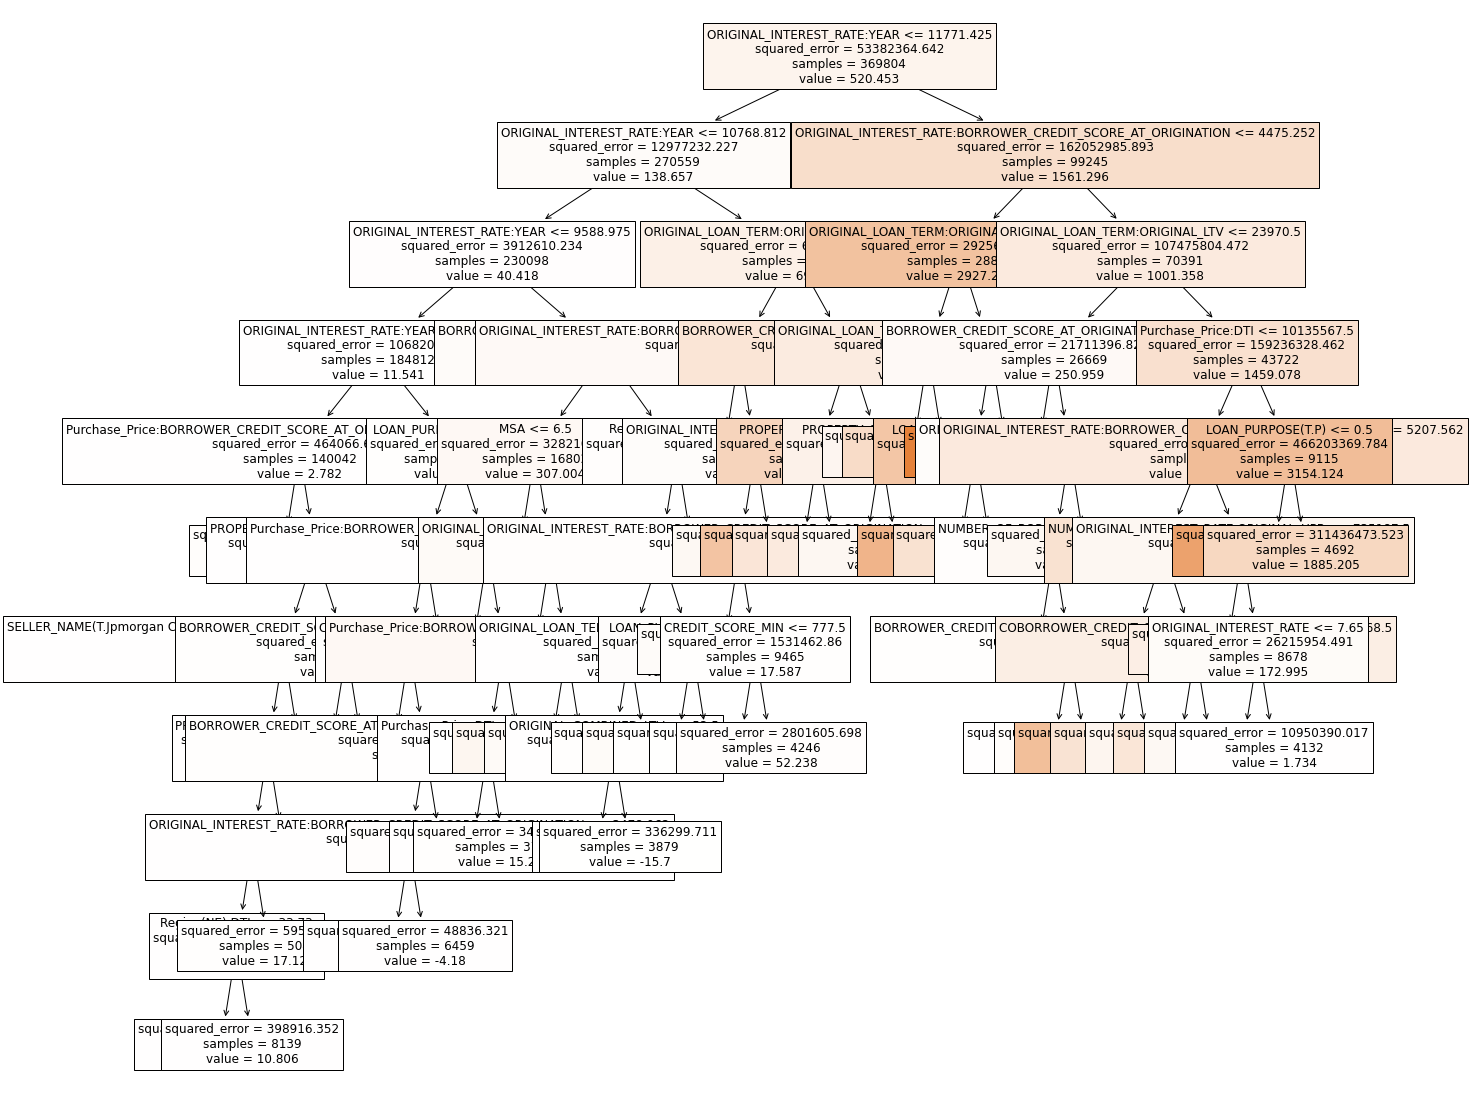

In [65]:
plt.figure(figsize=(20,20))
plot_tree(dt_model, feature_names=X_tree_train.columns, filled=True, fontsize=12)
plt.show()

We can also look at the feature importance.

In [66]:
dt_imp = pd.DataFrame({'Importance': dt_model.feature_importances_}, index=X_tree_train.columns).sort_values(['Importance'], ascending=False)

Below we are looking at the importance of various variables.  We look at the head and tail and this was an important part of our data methodology process for analyzing the data and picking our variables

In [ ]:
dt_imp.tail(20)

,Importance
"SELLER_NAME(T.Flagstar Bank, Fsb):CREDIT_SCORE_MIN",0.0
"SELLER_NAME(T.Gmac Mortgage, Llc):CREDIT_SCORE_MIN",0.0
"SELLER_NAME(T.Wells Fargo Bank, N.A.):AMORTIZATION_TYPE(OTHER)",0.0
SELLER_NAME(T.Suntrust Mortgage Inc.):AMORTIZATION_TYPE(OTHER),0.0
"SELLER_NAME(T.Quicken Loans, LLC):AMORTIZATION_TYPE(OTHER)",0.0
SELLER_NAME(T.Quicken Loans Inc.):AMORTIZATION_TYPE(OTHER),0.0
SELLER_NAME(T.Other):AMORTIZATION_TYPE(OTHER),0.0
SELLER_NAME(T.OTHER):AMORTIZATION_TYPE(OTHER),0.0
"SELLER_NAME(T.Jpmorgan Chase Bank, National Association):AMORTIZATION_TYPE(OTHER)",0.0
"SELLER_NAME(T.Jpmorgan Chase Bank, Na):AMORTIZATION_TYPE(OTHER)",0.0


In [68]:
dt_pred = dt_model.predict(X_tree_validation)

In [69]:
accuracy(df_validation['NET_LOSS'], dt_pred)   

RMSE,Naive - RMSE
7373.181787,83.217849


Let's plot the binned predicted versus actual net loss.  We lowered our bin_size to 200 to see more data points

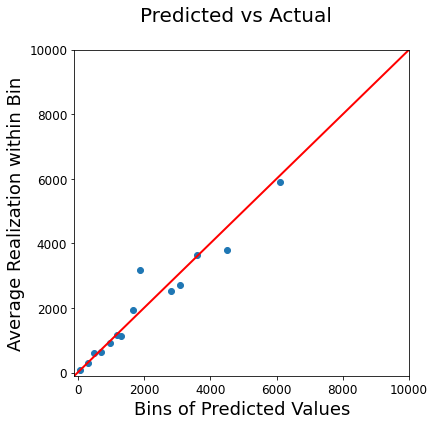

In [70]:
predictions = pd.Series(dt_pred)
realizations = df_validation['NET_LOSS'].reset_index(drop=True)

lower_limit = 0
upper_limit = 10000
bin_size = 200 #lower bins means more points

bins = list(np.arange(lower_limit, upper_limit, bin_size))

bin_indices = []
for i in range(len(bins) - 1):
    bin_indices.append(predictions[(predictions > bins[i-1]) & (predictions <= bins[i])].index.to_numpy())

x_values = []
y_values = []
for i in range(len(bins) - 1):
    x_values.append(np.mean(predictions[bin_indices[i]]))
    y_values.append(np.mean(realizations[bin_indices[i]]))

plt.figure(figsize=(6,6))
plt.scatter(x_values, y_values)
plt.xlim(lower_limit - 100, upper_limit)
plt.ylim(lower_limit - 100, upper_limit)
plt.plot([lower_limit - 100, upper_limit], [lower_limit - 100, upper_limit], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('Bins of Predicted Values', fontsize=18)
plt.ylabel('Average Realization within Bin', fontsize=18)
plt.show()

### About our decision tree
We don't use the decision tree as part of our final ensemble, but we do use our decision tree to get a better understanding of the data and how our variables effect the way each data point is scored.
We also used the decision tree as part of our original model testing and formula design before moving on to the Random Forest and Gradient boosted models.

The decision tree was important in our early data science methodology process for analyzing the data and constructing our business problem/visualizations.

We decided to leave this tree in as it was still vital to our overall process even if it did not make it into our final ensembled model.

# Random forest

A random forest and the boosted trees may take a long time to run, particularly on the full dataset, so you should be careful what you run on the full dataset. If something is taking forever, you can hit the stop button in the toolbar or go to "Kernel -> Interrupt Kernel".

### Random Forest Optimizer

Below is a series of cells that were used to help hyper tune our parameters and optimize our model.

This cell sets all of the parameter ranges that we want to iterate through.

for each parameter, we provide a range of values that can be used in the RandomizedSearchCV functionality. Comments were added to each line

Here we create our parameter grid which will be passed through our RandomizedSearchCV function.  The print function will display all parameters and their range of values that will be iterated through.  

Stack Exchange was a source of help for a lot of the code.

In [71]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 10)] #a higher n_estimators should perform better but will slow things down, also risking overfitting so we'll need to also consider the testing data
# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]


max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

I've commented out the code below as this optimizer, and the others, takes quite a long time to get through and may crash.  The results of the RandomizedSearchCV were used in our model

In [72]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 231, 452, 673, 894, 1115, 1336, 1557, 1778, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


### Optimizer
as stated above, we have decided not to run the below code just due to the time it takes to run and compute.  For ease of use and running this code, we manually put the best parameters into the model and run it seperately.  The computation time can be long and occassionaly has resulted in the kernel dying before completion (resulting in the need to rerun it) so we are just bypassing that

In [73]:
## Use the random grid to search for best hyperparameters
## First create the base model to tune
#rf = RandomForestRegressor()
## Random search of parameters, using 3 fold cross validation, 
## search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1, cv = 2, verbose=2, random_state=rs, n_jobs = -1)
## Fit the random search model
#rf_random.fit(X_tree_train, y_tree_train)

In [74]:
#Here's what our best params look like
#rf_random.best_params_

Set up our model and train it.  Due to the parameters we retrieved from above, this too can take quite a while to run.  I suggest grabbing a cup of coffee

For our parameters, we narrowed some of these values down to a small range and just took the initial suggestion.  Additional fine tuning may be done manually, but considering the run times, we opted to just taking the initial results as they had improved our scores tremendously

In [75]:
#rf_pred = rf_random.predict(X_tree_validation)

In [76]:
%%time
rf_model = RandomForestRegressor(n_estimators=1557,
                                 max_features='sqrt',
                                 max_depth=90,
                                 min_samples_split=5,
                                 min_impurity_decrease=.1,
                                 min_samples_leaf = 2,
                                 random_state=rs,
                                 bootstrap = True,
                                 n_jobs=num_cpus)
rf_model.fit(X_tree_train, y_tree_train)

CPU times: user 44min 22s, sys: 2.35 s, total: 44min 24s
Wall time: 2min 48s


RandomForestRegressor(max_depth=90, max_features='sqrt',
                      min_impurity_decrease=0.1, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=1557, n_jobs=16,
                      random_state=201)

In [77]:
pd.DataFrame({'Importance': rf_model.feature_importances_}, index=X_tree_train.columns).sort_values(['Importance'], ascending=False)

,Importance
ORIGINAL_INTEREST_RATE:ORIGINAL_UPB,4.088046e-02
BORROWER_CREDIT_SCORE_AT_ORIGINATION:ORIGINAL_UPB,4.012212e-02
ORIGINAL_INTEREST_RATE:BORROWER_CREDIT_SCORE_AT_ORIGINATION,3.969831e-02
ORIGINAL_INTEREST_RATE:YEAR,3.913567e-02
Purchase_Price:BORROWER_CREDIT_SCORE_AT_ORIGINATION,3.888366e-02
...,...
SELLER_NAME(T.Quicken Loans Inc.):MORTGAGE_INSURANCE_PERCENTAGE,2.065686e-06
"SELLER_NAME(T.Quicken Loans, LLC):CREDIT_SCORE_MIN",6.873179e-07
"SELLER_NAME(T.Quicken Loans, LLC):AMORTIZATION_TYPE(OTHER)",5.913634e-07
"SELLER_NAME(T.Quicken Loans, LLC):MORTGAGE_INSURANCE_PERCENTAGE",5.689727e-08


Now we can predict on our validation set.

In [78]:
rf_pred = rf_model.predict(X_tree_validation)

In [79]:
accuracy(df_validation['NET_LOSS'], rf_pred) 

RMSE,Naive - RMSE
7264.345498,192.054138


Let's plot the binned predicted versus actual net loss.

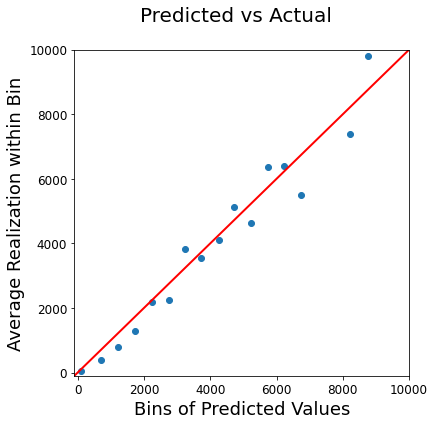

In [80]:
predictions = pd.Series(rf_pred)
realizations = df_validation['NET_LOSS'].reset_index(drop=True)

lower_limit = 0
upper_limit = 10000
bin_size = 500

bins = list(np.arange(lower_limit, upper_limit, bin_size))

bin_indices = []
for i in range(len(bins) - 1):
    bin_indices.append(predictions[(predictions > bins[i-1]) & (predictions <= bins[i])].index.to_numpy())

x_values = []
y_values = []
for i in range(len(bins) - 1):
    x_values.append(np.mean(predictions[bin_indices[i]]))
    y_values.append(np.mean(realizations[bin_indices[i]]))

plt.figure(figsize=(6,6))
plt.scatter(x_values, y_values)
plt.xlim(lower_limit - 100, upper_limit)
plt.ylim(lower_limit - 100, upper_limit)
plt.plot([lower_limit - 100, upper_limit], [lower_limit - 100, upper_limit], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('Bins of Predicted Values', fontsize=18)
plt.ylabel('Average Realization within Bin', fontsize=18)
plt.show()

# Boosted trees model

Let's look at a boosted trees model.  This model is one we discovered to be incredibly powerful in the initial run, so we decided to keep it and make sure it is part of our final ensemble.

This model, however, takes a wildly long time to optimize (multiple hours, assuming it finishes) so we have instead opted to comment out all of the optimization features and just manually upload the best params we were able to generate at the time.

In [81]:
classifier = XGBClassifier()
xgb1 = XGBRegressor()

In [82]:
#xg_random = RandomizedSearchCV(classifier, param_distributions = parameters, n_iter = 1, cv = 2, verbose=5, random_state=rs, n_jobs = -1)

Here are our parameters that we were trying to optimize.  We also took a look at individual scores to see how the model performs given different conditions.

In [83]:
scoring= ['accuracy', 'precision','recall']
parameters = {#'nthread':[3,4], #when use hyperthread, xgboost may become slower
              "max_features":["log2","sqrt"],
              'learning_rate': [0.01,0.05,0.1,1,0.5], #so called `eta` value
                
              'scoring':scoring

              }



Here we run our randomized search on parameters

In [84]:
# ###sorted(sklearn.metrics.SCORERS.keys()) # To see different loss functions
#xg_search = RandomizedSearchCV(classifier, parameters, random_state=rs,n_iter = 1, n_jobs=-1,cv = 2)

#xg_search.fit(X_tree_train,y_tree_train)


This will print our best parameters and scores, re-iterating above that these are commented out due to the time it took to run.

In [85]:
#xg_search.best_params_

fitting our model

In [86]:
#xg_random.fit(X_tree_train, y_tree_train)

and one final look at the best parameters that have been passed through

In [87]:
#Here's what our best params look like
#xg_random.best_params_

In [88]:
%%time
xgb_model = XGBRegressor(max_depth=7,
                         n_estimators = 70,
                         learning_rate=.1,
                         random_state=rs,
                         n_jobs=num_cpus)
xgb_model.fit(X_tree_train, y_tree_train)

CPU times: user 6min 59s, sys: 3.16 s, total: 7min 2s
Wall time: 26.8 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=70, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=201,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

We can also look at the feature importance.

In [89]:
pd.DataFrame({'Importance': xgb_model.feature_importances_}, index=X_tree_train.columns).sort_values(['Importance'], ascending=False)

,Importance
BORROWER_CREDIT_SCORE_AT_ORIGINATION:Region(W),0.028863
PROPERTY_STATE(T.CA),0.024660
PROPERTY_STATE(T.PA),0.020316
PROPERTY_STATE(T.WA),0.018598
Purchase_Price:Region(T.W),0.018520
...,...
PROPERTY_STATE(T.TX),0.000000
Purchase_Price:PROPERTY_STATE(OR):MORTGAGE_INSURANCE_PERCENTAGE,0.000000
SELLER_NAME(T.Quicken Loans Inc.):CREDIT_SCORE_MIN,0.000000
Purchase_Price:Region(T.OTHER),0.000000


Now we can predict on our validation set.

In [90]:
xgb_pred = xgb_model.predict(X_tree_validation)

In [91]:
accuracy(df_validation['NET_LOSS'], xgb_pred)

RMSE,Naive - RMSE
7264.019144,192.380492


Let's plot the binned predicted versus actual net loss

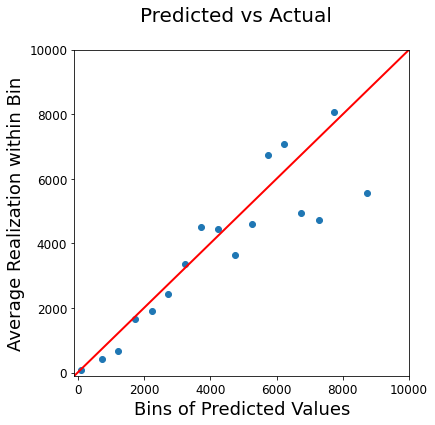

In [92]:
predictions = pd.Series(xgb_pred)
realizations = df_validation['NET_LOSS'].reset_index(drop=True)

lower_limit = 0
upper_limit = 10000
bin_size = 500

bins = list(np.arange(lower_limit, upper_limit, bin_size))

bin_indices = []
for i in range(len(bins) - 1):
    bin_indices.append(predictions[(predictions > bins[i-1]) & (predictions <= bins[i])].index.to_numpy())

x_values = []
y_values = []
for i in range(len(bins) - 1):
    x_values.append(np.mean(predictions[bin_indices[i]]))
    y_values.append(np.mean(realizations[bin_indices[i]]))

plt.figure(figsize=(6,6))
plt.scatter(x_values, y_values)
plt.xlim(lower_limit - 100, upper_limit)
plt.ylim(lower_limit - 100, upper_limit)
plt.plot([lower_limit - 100, upper_limit], [lower_limit - 100, upper_limit], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('Bins of Predicted Values', fontsize=18)
plt.ylabel('Average Realization within Bin', fontsize=18)
plt.show()

## Predict on the Test Set

After you have gone through and chosen your specific model and the parameters from the model using your validation set, it is now time to go back and redo everything on the full training set in order to make predictions on the test set. Note that the below will assume you want to make the same choices around formatting data as you did for the `df_smaller_train` set above. The below is really just going through the above steps to create the data but replacing `df_smaller_train` with `df_train` and `df_validation` with `df_test`.

First, we will refit the imputers and impute on `df_train` and `df_test`.

In [93]:
imputer_mean_final = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer_zero_final = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
categorical_imputer_final = CategoricalImputer(other_threshold=.01)

In [94]:
imputer_mean_final.fit(df_train[continuous_mean])
df_train[continuous_mean] = imputer_mean_final.transform(df_train[continuous_mean])
df_test[continuous_mean] = imputer_mean_final.transform(df_test[continuous_mean])

In [95]:
imputer_zero_final.fit(df_train[continuous_zero])
df_train[continuous_zero] = imputer_zero_final.transform(df_train[continuous_zero])
df_test[continuous_zero] = imputer_zero_final.transform(df_test[continuous_zero])

In [96]:
categorical_imputer_final.fit(df_train[categorical_variables])
df_train[categorical_variables] = categorical_imputer_final.transform(df_train[categorical_variables])
df_test[categorical_variables] = categorical_imputer_final.transform(df_test[categorical_variables])

Now, we will re-create the linear regression data necessary to train and predict. This will use the same `formula_linear` you created when you were first training the logistic regression.

Now, we will recreate the tree based models data set.

In [97]:
X_tree_train_final = df_train[continuous_features_trees + cat_ordinal_features_trees]
y_tree_train_final = df_train['NET_LOSS']

If you created dummy variables or interactions, you will want to run the next line. If not, you can skip it. This will use the same `formula_tree` you made when first setting up the data set for trees.

In [98]:
X_tree_train_patsy_final = dmatrix(formula_tree, df_train, return_type="dataframe")
X_tree_train_final = pd.concat([X_tree_train_final, X_tree_train_patsy_final], axis=1)

Now we ordinal encode variables. If you did not choose to ordinal encode any variables, you can skip this.

In [99]:
ordinal_encoder_final = OrdinalEncoder()
ordinal_encoder_final.fit(X_tree_train_final[cat_ordinal_features_trees])
X_tree_train_final[cat_ordinal_features_trees] = ordinal_encoder_final.transform(X_tree_train_final[cat_ordinal_features_trees])

Finally, we have to replace the characters that xgboost doesn't like.

In [100]:
X_tree_train_final.columns = X_tree_train_final.columns.str.replace('[', '(').str.replace(']', ')')

/tmp/ipykernel_673/3936873654.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_tree_train_final.columns = X_tree_train_final.columns.str.replace('[', '(').str.replace(']', ')')


Remove duplicate columns for safe measure

In [101]:
X_tree_train_final = X_tree_train_final.loc[:,~X_tree_train_final.columns.duplicated()]

same as above, but for the test set

In [102]:
X_tree_test = df_test[continuous_features_trees + cat_ordinal_features_trees]
y_tree_test = df_test['NET_LOSS']

X_tree_test_patsy = build_design_matrices([X_tree_train_patsy_final.design_info], df_test, return_type="dataframe")[0]

X_tree_test = pd.concat([X_tree_test, X_tree_test_patsy], axis=1)

X_tree_test[cat_ordinal_features_trees] = ordinal_encoder_final.transform(X_tree_test[cat_ordinal_features_trees])

X_tree_test.columns = X_tree_test.columns.str.replace('[', '(').str.replace(']', ')')

X_tree_test = X_tree_test.loc[:,~X_tree_test.columns.duplicated()]

/tmp/ipykernel_673/4054450208.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_tree_test.columns = X_tree_test.columns.str.replace('[', '(').str.replace(']', ')')


Now we can retrain our tree based models, and make final predictions. Note you should adjust parameters to whatever you found above, and you may not need to run all of the below code if you don't intend to use some of the models.

Here is our random forest model with the sama parameters as used above in the training part

In [103]:
%%time
rf_model_final = RandomForestRegressor(n_estimators=1557,
                                 max_features='sqrt',
                                 max_depth=90,
                                 min_samples_split=5,
                                 min_impurity_decrease=.1,
                                 min_samples_leaf = 2,
                                 random_state=rs,
                                 bootstrap = True,
                                 n_jobs=num_cpus)
rf_model_final.fit(X_tree_train_final, y_tree_train_final)
rf_pred_final = rf_model_final.predict(X_tree_test)

[CV] END max_depth=10, max_features=auto, min_samples_leaf=0.01, min_samples_split=1100; total time=   3.8s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=0.01, min_samples_split=1100; total time=   3.9s
CPU times: user 1h 8min 24s, sys: 3.31 s, total: 1h 8min 27s
Wall time: 4min 20s


Training the boosted tree

In [104]:
%%time
xgb_model_final = XGBRegressor(max_depth=7,
                         n_estimators = 70,
                         learning_rate=.1,
                         random_state=rs,
                         n_jobs=num_cpus)
xgb_model_final.fit(X_tree_train_final, y_tree_train_final)
xgb_pred_final = xgb_model_final.predict(X_tree_test)

CPU times: user 9min 15s, sys: 4.04 s, total: 9min 19s
Wall time: 35.6 s


Now you can choose to ensemble however you would like. Below is one possibility of just ensembling all of the above models equally.

# Ensembling
Here, I am trying to find some sort of optimal weight dsitribution for models

I wrote a function to iterate through a series of weights by increments of .05.  Then, it would pass every combination that totaled 1.0 and distributed those weights to the model, then scored them and compares the outputs.

We take the best output.  There are definitely better ways, and cleaner ways to have gone through this series of steps, but given the time constraints, I opted to just hard code weights and brute force my way to an answer.  I wanted to try to squeeze every last bit of optimization I could out of this.

In [105]:
def weighted_best(model1, model2):
    weight1 = np.arange(0, 1, 0.05).tolist()
    weight2 = np.arange(0, 1, 0.05).tolist()
    for i in weight1:
        for j in weight2:
            if i + j == 1.0:
                final_pred_wt = ((i)*(model1)+(j)*(model2))
                accuracy(df_test['NET_LOSS'], final_pred_wt)
                print(i)
                print(j)
            else:
                pass
        pass
    pass

Here we are printing out our weights and the accuracy scores.  These are default tuned to a random seed of 201, so reruns would need some more tuning, or better yet, would be automated as part of the process.  We print out the scores and weights to see how things change

In [106]:
weighted_best(rf_pred_final, xgb_pred_final)

RMSE,Naive - RMSE
7178.614623,185.891193


0.05
0.9500000000000001


RMSE,Naive - RMSE
7175.121698,189.384118


0.1
0.9


RMSE,Naive - RMSE
7172.063999,192.441817


0.15000000000000002
0.8500000000000001


RMSE,Naive - RMSE
7169.442081,195.063735


0.2
0.8


RMSE,Naive - RMSE
7167.256426,197.249391


0.25
0.75


RMSE,Naive - RMSE
7165.507430,198.998386


0.30000000000000004
0.7000000000000001


RMSE,Naive - RMSE
7164.195415,200.310401


0.35000000000000003
0.65


RMSE,Naive - RMSE
7163.320620,201.185196


0.4
0.6000000000000001


RMSE,Naive - RMSE
7162.883206,201.622610


0.45
0.55


RMSE,Naive - RMSE
7162.883253,201.622564


0.5
0.5


RMSE,Naive - RMSE
7163.320760,201.185056


0.55
0.45


RMSE,Naive - RMSE
7164.195647,200.310169


0.6000000000000001
0.4


RMSE,Naive - RMSE
7165.507755,198.998061


0.65
0.35000000000000003


RMSE,Naive - RMSE
7167.256843,197.248973


0.7000000000000001
0.30000000000000004


RMSE,Naive - RMSE
7169.442592,195.063225


0.75
0.25


RMSE,Naive - RMSE
7172.064601,192.441215


0.8
0.2


RMSE,Naive - RMSE
7175.122393,189.383423


0.8500000000000001
0.15000000000000002


RMSE,Naive - RMSE
7178.615412,185.890405


0.9
0.1


RMSE,Naive - RMSE
7182.543021,181.962795


0.9500000000000001
0.05


These are the weights we find are best for random_state 201.  If there was time, I would automate this whole process, and find a way to list these results in an array or a dataframe and pick the max values

In [121]:
w1 = .45
w2 = .55

Our final weighted predictions are below

In [122]:
final_pred = ((w1)*(rf_pred_final)+(w2)*(xgb_pred_final))

Now, see you skill score on your final prediction.

In [123]:
acc = accuracy(df_test['NET_LOSS'], final_pred)

RMSE,Naive - RMSE
7162.883206,201.622610


Let's plot this bad boy, just for the visual.  I lowered the bin_size value to 200 for now just to see more plots on the graph.

The higher value loans have more variance.  We are underpredicting a bit at the higher value loans

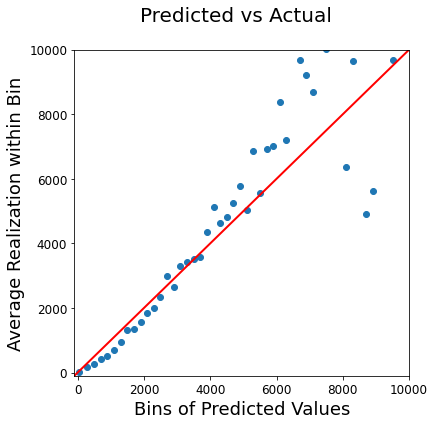

In [124]:
predictions = pd.Series(final_pred)
realizations = df_test['NET_LOSS'].reset_index(drop=True)

lower_limit = 0
upper_limit = 10000
bin_size = 200

bins = list(np.arange(lower_limit, upper_limit, bin_size))

bin_indices = []
for i in range(len(bins) - 1):
    bin_indices.append(predictions[(predictions > bins[i-1]) & (predictions <= bins[i])].index.to_numpy())

x_values = []
y_values = []
for i in range(len(bins) - 1):
    x_values.append(np.mean(predictions[bin_indices[i]]))
    y_values.append(np.mean(realizations[bin_indices[i]]))

plt.figure(figsize=(6,6))
plt.scatter(x_values, y_values)
plt.xlim(lower_limit - 100, upper_limit)
plt.ylim(lower_limit - 100, upper_limit)
plt.plot([lower_limit - 100, upper_limit], [lower_limit - 100, upper_limit], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('Bins of Predicted Values', fontsize=18)
plt.ylabel('Average Realization within Bin', fontsize=18)
plt.show()

## Set a Threshold and Compute Revenue

Ultimately, we care about using the predictions of the model to decide whether or not to accept a mortgage application. Therefore, we have to decide what we consider to be too high of a probability of default before we reject a loan application. However, if we reject a loan application that does not default, we lose some potential revenue.

We will load in a fresh copy of the data to ensure we are computing the correct revenue.

In [125]:
%%time
if not full_data_set:
    df_test_fresh = pd.read_csv(FILES_LOCATION + "FannieMaeSmallTest.csv",
                          index_col="LOAN_IDENTIFIER",
                          dtype=col_classes,
                          parse_dates=date_columns,
                          sep='|')
elif full_data_set:
    df_test_fresh = pd.read_csv(FILES_LOCATION + "FannieMaeTest.csv",
                          index_col="LOAN_IDENTIFIER",
                          dtype=col_classes,
                          parse_dates=date_columns,
                          sep='|')

CPU times: user 3.04 s, sys: 91.8 ms, total: 3.13 s
Wall time: 3.14 s


One way of doing this is by setting a threshold where if the probability of default is lower than the threshold, accept the loan. Therefore, we can set the threshold either too high or too low. If it is too high, we lose out on potential revenue from accepting good loans, but if it too low, we take losses on loans that do default.

The below function will take in your predictions and a threshold, and it will produce a list of `True` and `False` values where `True` means you accept the loan and `False` means you do not accept the loan.

In [126]:
def accept_by_predicted_loss(predictions, threshold):
    return predictions <= threshold

You can use it like below:

In [127]:
loan_decisions = accept_by_predicted_loss(final_pred, 2850)

## Loan Decision
If we accept a predicted loss of $2850, we can accept about 95% of loans

In [128]:
loan_decisions.mean()

0.9505468764260059

This code is provided to us in the original Fannie Mae jupyter notebook and was used for our final.

The below function will take in your loan decisions and compute the revenue (in millions) from the accepted loans.

In [129]:
def loan_loss_revenue(loans_accepted):
    revenue = (df_test_fresh[loan_decisions]['ORIGINAL_VALUE']*.005).sum() - df_test_fresh[loan_decisions]['NET_LOSS'].sum()
    return revenue/1000000

The revenue generated per loan is set at .5% of the original loan value. This is taken from the Quarterly Mortgage Bankers Performance Report, Q1 2018, where the average revenue per loan was about \\$1500. Since the average loan size in the Fannie Mae data set for 2018 was \\$330,000, this amounts to roughly .5% of the original loan value as revenue for the average mortgage banker in this time period. So, if you accept a loan (whether or not the loan ultimately defaults), the `loan_loss_revenue` will add .5% of the loan value for that loan.

However, if you accept a loan that does default, then the `NET_LOSS` of that loan will be subtracted from your total revenue.

This function allows you to compute the expected revenue from accepting your recommendations. You can use it as below.

In [130]:
loan_loss_revenue(loan_decisions)

645.0544422469242

### Let's pickle

We're gonna save our model just to be double sure that we can recreate these values again.

In [131]:
with open("final_xgb_model.pkl", 'wb') as f:
    dill.dump(xgb_model_final, f)

In [132]:
with open("final_rf_model.pkl", 'wb') as f:
    dill.dump(rf_model_final, f)

## Write out the data with your predictions

It is often helpful to take our predictions after we have made them, and visualize our errors to get a sense for how we might want to change and improve our model. Here we will append our predictions to the original testing set, and then we will write out the testing set with our predictions appended so that you can download the csv file and use Tableau to iterate on your model.

You will need the `df_test_fresh` data set loaded in the computing revenue section of this notebook. Once we have that you can add your predictions.

In [119]:
df_test_fresh['PREDICTIONS_NET_LOSS'] = final_pred

Write out the csv of the data with your predictions. Download this csv from Jupyterhub and use this csv in Tableau to study your predictions geographically and try to determine where you might be making errors.

In [120]:
df_test_fresh.to_csv('FannieMaeTestWithPredictionsNetLoss.csv', sep='|')

If you identify any systematic mistakes, then go back to the model building part of the exercise and try to correct them!